In [7]:
import random
import numpy as np
import networkx as nx 
from dijkstar import Graph, find_path
from ipywidgets import IntProgress 
from IPython.display import display
from matplotlib import pyplot as plt


In [8]:
def get_complete_path(path, all_paths):
  complete_path = []
  for i in range(len(path) - 1):
    complete_path.extend(all_paths[(path[i], path[i+1])][:-1])
    if i == len(path) - 2:
      complete_path.append(all_paths[(path[i], path[i+1])][-1])
  return complete_path

def is_path_in_interval(path, complete_graph, interval, interval_vertex):
  weight = 0
  for i in range(np.where(np.array(path) == interval_vertex)[0][0]):
    weight += complete_graph[path[i]][path[i+1]]
  if weight >= interval[0] and weight <= interval[1]:
    return True
  else:
    return False

In [9]:
population_number = 200
generation_number = 200

In [10]:
def get_path_weight(path, complete_graph):
  weight = 0
  for i in range(len(path) - 1):
    weight += complete_graph[path[i]][path[i+1]]
  return weight

def generate_population(nb_people, complete_graph, interval, interval_vertex, start_vertex):
  population = []
  while(len(population) < nb_people):
    path = generate_random_path(len(complete_graph), start_vertex)
    if is_path_in_interval(path, complete_graph, interval, interval_vertex):
      population.append(path)
  return population

def get_best_path(population, weights):
  index = np.argmin(weights)
  return population[index], weights[index]

def generate_instance_matrix(nb_vertex, min_weight, max_weight, density):
  graph = np.ones((nb_vertex, nb_vertex)) * np.inf
  for i in range(nb_vertex - 1):
    for j in range(i+1, nb_vertex):
      if random.uniform(0, 1) < density:
        weight = random.randint(min_weight, max_weight)
        graph[i, j] = weight
        graph[j, i] = weight
  for i, successors in enumerate(graph):
    index_zeros = np.where(successors == np.inf)[0]
    index_zeros = np.delete(index_zeros, np.where(index_zeros == i))
    for j in range(len(index_zeros) - (nb_vertex - 3)):
      index = random.choice(index_zeros)
      index_zeros = np.delete(index_zeros, np.where(index_zeros == index))
      weight = random.randint(min_weight, max_weight)
      graph[i, index] = weight
      graph[index, i] = weight
  return graph

def generate_instance_matrix_localisation(nb_vertex, density):
  all_vertex = {}
  for i in range(nb_vertex):
    all_vertex[i] = (random.randint(0, 1000), random.randint(0, 1000))
  graph = np.ones((nb_vertex, nb_vertex)) * np.inf
  for i in range(nb_vertex - 1):
    for j in range(i+1, nb_vertex):
      if random.uniform(0, 1) < density:
        delta_x = all_vertex[i][0] - all_vertex[j][0]
        delta_y = all_vertex[i][1] - all_vertex[j][1]
        weight = np.sqrt(np.power(delta_x,2) + np.power(delta_y,2))
        graph[i, j] = weight
        graph[j, i] = weight
  for i, successors in enumerate(graph):
    index_zeros = np.where(successors == np.inf)[0]
    index_zeros = np.delete(index_zeros, np.where(index_zeros == i))
    for j in range(len(index_zeros) - (nb_vertex - 3)):
      index = random.choice(index_zeros)
      index_zeros = np.delete(index_zeros, np.where(index_zeros == index))
      delta_x = all_vertex[i][0] - all_vertex[j][0]
      delta_y = all_vertex[i][1] - all_vertex[j][1]
      weight = np.sqrt(np.power(delta_x,2) + np.power(delta_y,2))
      graph[i, j] = weight
      graph[j, i] = weight
  return graph, all_vertex

def convert_graph(graph):
  graph_dijkstra = Graph()
  for i in range(len(graph)):
    for j in range(len(graph)):
      graph_dijkstra.add_edge(i, j,graph[i][j])
  return graph_dijkstra

def get_distance_between_vertices(graph, i, j):
  if (graph[i][j] != np.inf):
    return graph[i][j], [i, j]
  else:
    if i != j:
      shortest_path = find_path(graph, i,j)
      return shortest_path.total_cost, shortest_path.nodes
    else:
      return 0, None

def get_complete_graph(graph, vertices_list):
  all_paths = {}
  converted_graph = convert_graph(graph)
  complete_graph = np.zeros((len(vertices_list), len(vertices_list)))
  bar = IntProgress(min=0, max=len(vertices_list), layout={"width" : "100%"})
  display(bar)
  for vertex in vertices_list:
    successors = np.delete(vertices_list, np.where(vertices_list == vertex))
    bar.value += 1
    for successor in successors:
      distance, path = get_distance_between_vertices(converted_graph, vertex, successor)
      i = np.where(vertices_list == vertex)[0][0]
      j = np.where(vertices_list == successor)[0][0]
      complete_graph[i][j] = distance
      all_paths[(i, j)] = path
  bar.close()
  return complete_graph, all_paths

def get_random_vertices_list(size, nb_vertex):
  random_vertices_list = []
  all_vertex = np.array(range(size))
  for _ in range(nb_vertex):
    value = random.choice(all_vertex)
    random_vertices_list.append(value)
    all_vertex = np.delete(all_vertex, np.where(all_vertex == value))
  return np.array(random_vertices_list)

def generate_interval():
  interval = random.choice(range(1,4))
  shift = random.choice(range(0, 11-interval))
  return (shift*60, (shift+interval)*60)

def generate_instance(nb_vertex_matrix, density, vertices_list):
  graph, all_vertex  = generate_instance_matrix_localisation(nb_vertex_matrix, density)
  complete_graph, all_paths = get_complete_graph(graph, vertices_list)
  return graph, complete_graph, all_paths, all_vertex

def is_path_in_interval(path, complete_graph, interval, interval_vertex):
  weight = 0
  for i in range(np.where(np.array(path) == interval_vertex)[0][0]):
    weight += complete_graph[path[i]][path[i+1]]
  if weight >= interval[0] and weight <= interval[1]:
    return True
  else:
    return False

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path

def get_random_vertex(random_vertex):
  return random.choice(random_vertex)
  


In [11]:
def mutate_path_insert(path, complete_graph, interval, interval_vertex):
  is_path_correct = False
  while not is_path_correct:
    start = path[0]
    path = np.delete(path, np.where(path == start))
    mutation = random.choice(path)
    path = np.delete(path, np.where(path == mutation))
    new_index = random.randint(0, len(path) - 1)
    path = np.insert(path, new_index, mutation)
    path = np.append(path, start)
    path = np.insert(path, 0, start)
    is_path_correct = is_path_in_interval(path, complete_graph, interval, interval_vertex)
  return path

def generate_children(parentA, parentB, complete_graph, interval, interval_vertex):
  start = parentA[0]
  parentA = np.delete(parentA, np.where(np.array(parentA) == start))
  parentB = np.delete(parentB, np.where(np.array(parentB) == start))
  is_path_correct = False
  while not is_path_correct:
    cut_start = random.randint(0, len(parentA) - 2)
    cut_end = random.randint(cut_start + 1, len(parentA) - 1)
    child = parentA[cut_start:cut_end]
    for i in child:
      remaining_parentB = np.delete(parentB, np.where(parentB == i))
    child = np.insert(child, len(child), remaining_parentB)
    child = np.append(child, start)
    child = np.insert(child, 0, start)
    is_path_correct = is_path_in_interval(child, complete_graph, interval, interval_vertex)
  return child

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path

def get_best_population(population):
  return np.argpartition(population, -int(len(population)/4))[:int(len(population)/4)]

def generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index):
  children = []
  for _ in range(population_number):
    P1 = random.choice(best_people)
    # child = generate_children(P1, P2, complete_graph, interval, interval_vertex_index)
    child = mutate_path_insert(P1, complete_graph, interval, interval_vertex_index)
    children.append(child)
  return children

def evalute_population_weight(population, complete_graph):
  weights = []
  for path in population:
    weight = get_path_weight(path, complete_graph)
    weights.append(weight)
  return weights

def evolve(population, complete_graph, interval, interval_vertex_index):
  best_weight = np.inf
  best_path = []
  all_best_weights = np.array([])
  bar = IntProgress(min=0, max=generation_number, layout={"width" : "100%"})
  display(bar)
  for i in range(generation_number):
    bar.value += 1
    weights = evalute_population_weight(population, complete_graph)
    best_pop_path, best_pop_weight = get_best_path(population, weights)
    all_best_weights = np.append(all_best_weights,best_pop_weight)
    if(best_pop_weight < best_weight):
      best_weight = best_pop_weight
      best_path = best_pop_path
    best_people = np.array(population)[get_best_population(weights)]
    population = generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index)
  bar.close()
  return best_path, best_weight, all_best_weights

def plot_graph(path, graph, all_vertex, all_verticies, start_vertex):
  for i in range(len(graph) - 1):
    for j in range(i + 1, len(graph)):
      if graph[i, j] != np.inf:
        x = [all_vertex[i][0], all_vertex[j][0]]
        y = [all_vertex[i][1], all_vertex[j][1]]
        plt.plot(x, y, color = "gray")
  for i in range(len(path) - 1):
    x = [all_vertex[path[i]][0], all_vertex[path[i+1]][0]]
    y = [all_vertex[path[i]][1], all_vertex[path[i+1]][1]]
    plt.plot(x, y, color = "red")
  for i in range(len(all_vertex)):
    if(i == start_vertex):
      plt.scatter(all_vertex[i][0], all_vertex[i][1], color = "blue")
    elif(i in all_verticies):
      plt.scatter(all_vertex[i][0], all_vertex[i][1], color = "green")
    else: 
      plt.scatter(all_vertex[i][0], all_vertex[i][1], color = "gray")
    plt.text(all_vertex[i][0] - 10, all_vertex[i][1] + 20, str(i))
  plt.show()

In [12]:
import pickle
with open("data_extra_small_non_complet.pickle", "rb") as file:
  data = pickle.load(file)

graph = data["graph"]
complete_graph = data["complete_graph"]
all_paths = data["all_paths"]
vertices_list = data["vertices_list"]
start_vertex = data["start_vertex"]
start_vertex_index = data["start_vertex_index"]
interval_vertex = data["interval_vertex"]
interval_vertex_index = data["interval_vertex_index"]
interval = data["interval"]
all_vertex = data["all_vertex"]

population = generate_population(population_number, complete_graph, interval, interval_vertex_index, start_vertex_index)
best_path, best_weight, all_best_weights = evolve(population, complete_graph, interval, interval_vertex_index)

print(best_path, best_weight)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

[4 1 5 6 9 8 0 3 7 2 4] 4470.49406184854


-----------------
-----------------
1 Optimal 4470.494061848541
route_plan [[(0, 3), (3, 7), (7, 2), (2, 4), (4, 1), (1, 5), (5, 6), (6, 8), (8, 9), (9, 0)]]
liste_route_plan [0, 3, 7, 2, 4, 1, 5, 6, 8, 9, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [2, 2, 1]
Time taken by DFJ formulation =  0.2316570281982422


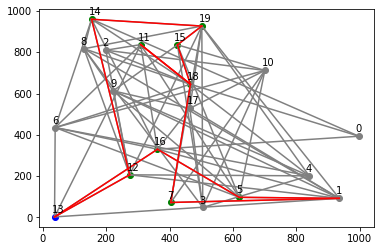

In [13]:
#import libraries
%matplotlib inline
import pulp
import pandas as pd
import time
import copy


# this function find all the subtour in the LP solution.
def get_plan(r0):
    r=copy.copy(r0)
    route = []
    while len(r) != 0:
        plan = [r[0]]
        del (r[0])
        l = 0
        while len(plan) > l:
            l = len(plan)
            for i, j in enumerate(r):
                if plan[-1][1] == j[0]:
                    plan.append(j)
                    del (r[i])
        route.append(plan)
    return(route)


def Simplex(complete_graph):

    no_of_locs = len(complete_graph)


    dis_mat= complete_graph

    start_t_1=time.time()
    model=pulp.LpProblem('tsp',pulp.LpMinimize)
    #define variable
    x=pulp.LpVariable.dicts("x",((i,j) for i in range(no_of_locs) \
                                    for j in range(no_of_locs)),\
                            cat='Binary')
    #set objective
    model+=pulp.lpSum(dis_mat[i][j]* x[i,j] for i in range(no_of_locs) \
                        for j in range(no_of_locs))
    # st constraints
    for i in range(no_of_locs):
        model+=x[i,i]==0
        model+=pulp.lpSum(x[i,j] for j in range(no_of_locs))==1
        model += pulp.lpSum(x[j, i] for j in range(no_of_locs)) == 1
        
        
    status=model.solve()



    route=[(i,j) for i in range(no_of_locs) \
            for j in range(no_of_locs) if pulp.value(x[i,j])==1]
    route_plan=get_plan(route)
    subtour=[]

    while len(route_plan)!=1:
        for i in range(len(route_plan)):
            model+=pulp.lpSum(x[route_plan[i][j][0],route_plan[i][j][1]]\
                                for j in range(len(route_plan[i])))<=\
                                len(route_plan[i])-1


        status=model.solve()
        route = [(i, j) for i in range(no_of_locs) \
                    for j in range(no_of_locs) if pulp.value(x[i, j]) == 1]
        route_plan = get_plan(route)
        
        subtour.append(len(route_plan))

    print("-----------------")
    print(status,pulp.LpStatus[status],pulp.value(model.objective))
    print("route_plan",route_plan)

    out = [item for t in route_plan[0] for item in t]
    liste_out = list(dict.fromkeys(out))
    liste_out.insert(len(liste_out), liste_out[0])
    print("liste_route_plan",liste_out)
    


    print("no. of times LP model is solved = ",len(subtour))
    print("subtour log (no. of subtours in each solution))",subtour)
    print("Time taken by DFJ formulation = ", time.time()-start_t_1)

    return liste_out,pulp.value(model.objective)

print("-----------------")
liste_out,distance_obj = Simplex(complete_graph)
"""while is_path_in_interval(liste_out, complete_graph, interval, interval_vertex_index) != True:
        print("path is not in interval")
        liste_out,distance_obj = Simplex(complete_graph)"""

complete_path = get_complete_path(liste_out, all_paths)
plot_graph(complete_path, graph, all_vertex, vertices_list, start_vertex)




[13, 16, 5, 1, 7, 18, 11, 18, 15, 19, 14, 12, 13]


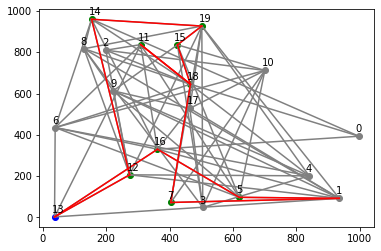

In [14]:
complete_path = get_complete_path(best_path, all_paths)
print(complete_path)
plot_graph(complete_path, graph, all_vertex, vertices_list, start_vertex)

Text(0, 0.5, 'weight')

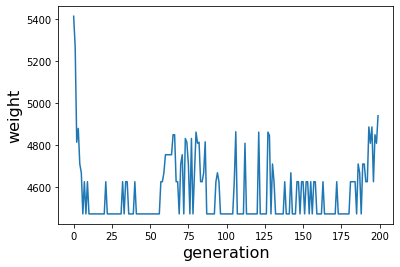

In [15]:
import matplotlib.pyplot as plt

res = plt.plot(range(len(all_best_weights)), all_best_weights)
plt.xlabel("generation", fontsize=16)
plt.ylabel("weight", fontsize=16)

In [16]:
nb_vertex_matrix = 100
min_weight = 10
max_weight = 60
density = 0.5
nb_vertex_chosen = 30

nb_test = 10

bornes_tab = []

for _ in range (nb_test):

    vertices_list = get_random_vertices_list(nb_vertex_matrix, nb_vertex_chosen)
    start_vertex = get_random_vertex(vertices_list)
    start_vertex_index = np.where(vertices_list == start_vertex)[0][0]

    interval_vertex = get_random_vertex(vertices_list)
    interval_vertex_index = np.where(vertices_list == interval_vertex)[0][0]

    interval = (0,100000000)

    # generation of the graph, the complete graph and the list of all paths
    graph, complete_graph, all_paths, all_vertex =\
    generate_instance(
    nb_vertex_matrix = nb_vertex_matrix,
    vertices_list = vertices_list,
    density = density
    )

    population = generate_population(population_number, complete_graph, interval, interval_vertex_index, start_vertex_index)
    best_path, best_weight, all_best_weights = evolve(population, complete_graph, interval, interval_vertex_index)
    borne_inf = Simplex(complete_graph)[1]
    distance_borne = borne_inf*100/best_weight
    bornes_tab.append(distance_borne)


    print("distance",distance_borne)
    print("borne_inf",borne_inf)
    print("best_weight",best_weight)

print(sum(bornes_tab) / len(bornes_tab))


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5906.832367607887
route_plan [[(0, 21), (21, 3), (3, 8), (8, 11), (11, 23), (23, 10), (10, 29), (29, 20), (20, 17), (17, 27), (27, 5), (5, 26), (26, 15), (15, 28), (28, 19), (19, 18), (18, 22), (22, 12), (12, 13), (13, 1), (1, 7), (7, 25), (25, 4), (4, 9), (9, 14), (14, 24), (24, 2), (2, 6), (6, 16), (16, 0)]]
liste_route_plan [0, 21, 3, 8, 11, 23, 10, 29, 20, 17, 27, 5, 26, 15, 28, 19, 18, 22, 12, 13, 1, 7, 25, 4, 9, 14, 24, 2, 6, 16, 0]
no. of times LP model is solved =  12
subtour log (no. of subtours in each solution)) [7, 6, 3, 3, 5, 6, 4, 2, 2, 3, 3, 1]
Time taken by DFJ formulation =  4.610421657562256
distance 76.1975705263041
borne_inf 5906.832367607887
best_weight 7751.995669689749


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

KeyboardInterrupt: 

Text(0.5, 1.0, 'Distribution des distances à la borne supérieure')

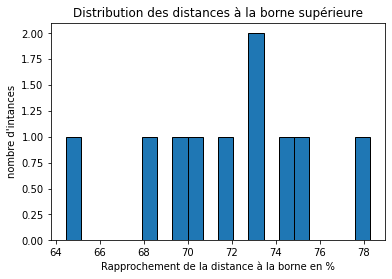

In [ ]:
plt.hist(bornes_tab,bins=20, edgecolor = "black")                         #SOLUTION
plt.xlabel("Rapprochement de la distance à la borne en %")                             #SOLUTION
plt.ylabel("nombre d'intances")                               #SOLUTION
plt.title("Distribution des distances à la borne supérieure") #SOLUTION

IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5418.978460963716
route_plan [[(0, 18), (18, 28), (28, 7), (7, 25), (25, 1), (1, 12), (12, 27), (27, 16), (16, 20), (20, 10), (10, 29), (29, 9), (9, 13), (13, 19), (19, 8), (8, 4), (4, 21), (21, 6), (6, 15), (15, 17), (17, 26), (26, 14), (14, 11), (11, 3), (3, 5), (5, 24), (24, 22), (22, 23), (23, 2), (2, 0)]]
liste_route_plan [0, 18, 28, 7, 25, 1, 12, 27, 16, 20, 10, 29, 9, 13, 19, 8, 4, 21, 6, 15, 17, 26, 14, 11, 3, 5, 24, 22, 23, 2, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [4, 3, 3, 2, 4, 4, 1]
Time taken by DFJ formulation =  2.011859655380249
distance 68.18856769402562
borne_inf 5418.978460963716
best_weight 7947.048375146474


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5819.320449475328
route_plan [[(0, 23), (23, 18), (18, 7), (7, 29), (29, 13), (13, 3), (3, 19), (19, 4), (4, 5), (5, 28), (28, 2), (2, 1), (1, 26), (26, 16), (16, 9), (9, 14), (14, 8), (8, 12), (12, 24), (24, 11), (11, 27), (27, 20), (20, 17), (17, 21), (21, 10), (10, 6), (6, 22), (22, 25), (25, 15), (15, 0)]]
liste_route_plan [0, 23, 18, 7, 29, 13, 3, 19, 4, 5, 28, 2, 1, 26, 16, 9, 14, 8, 12, 24, 11, 27, 20, 17, 21, 10, 6, 22, 25, 15, 0]
no. of times LP model is solved =  17
subtour log (no. of subtours in each solution)) [4, 8, 5, 4, 3, 3, 8, 4, 4, 3, 4, 3, 2, 2, 4, 3, 1]
Time taken by DFJ formulation =  10.323494911193848
distance 72.121638942359
borne_inf 5819.320449475328
best_weight 8068.757913455407


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5763.336726608557
route_plan [[(0, 25), (25, 12), (12, 15), (15, 2), (2, 20), (20, 29), (29, 7), (7, 11), (11, 9), (9, 22), (22, 24), (24, 6), (6, 3), (3, 8), (8, 19), (19, 16), (16, 10), (10, 26), (26, 23), (23, 1), (1, 4), (4, 17), (17, 13), (13, 21), (21, 18), (18, 27), (27, 14), (14, 5), (5, 28), (28, 0)]]
liste_route_plan [0, 25, 12, 15, 2, 20, 29, 7, 11, 9, 22, 24, 6, 3, 8, 19, 16, 10, 26, 23, 1, 4, 17, 13, 21, 18, 27, 14, 5, 28, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [6, 5, 3, 3, 3, 1]
Time taken by DFJ formulation =  1.7052054405212402
distance 72.25192227046759
borne_inf 5763.336726608557
best_weight 7976.72441853395


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5585.243018820966
route_plan [[(0, 16), (16, 6), (6, 14), (14, 12), (12, 7), (7, 27), (27, 22), (22, 1), (1, 4), (4, 29), (29, 17), (17, 19), (19, 8), (8, 26), (26, 24), (24, 21), (21, 10), (10, 15), (15, 13), (13, 5), (5, 28), (28, 23), (23, 2), (2, 9), (9, 3), (3, 18), (18, 11), (11, 25), (25, 20), (20, 0)]]
liste_route_plan [0, 16, 6, 14, 12, 7, 27, 22, 1, 4, 29, 17, 19, 8, 26, 24, 21, 10, 15, 13, 5, 28, 23, 2, 9, 3, 18, 11, 25, 20, 0]
no. of times LP model is solved =  24
subtour log (no. of subtours in each solution)) [5, 3, 3, 3, 2, 4, 3, 3, 3, 2, 4, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 2, 2, 1]
Time taken by DFJ formulation =  18.120814085006714
distance 72.84110048122575
borne_inf 5585.243018820966
best_weight 7667.708178380036


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5664.054148669059
route_plan [[(0, 13), (13, 6), (6, 10), (10, 21), (21, 3), (3, 5), (5, 15), (15, 22), (22, 24), (24, 26), (26, 25), (25, 4), (4, 2), (2, 27), (27, 23), (23, 11), (11, 9), (9, 7), (7, 18), (18, 16), (16, 20), (20, 28), (28, 29), (29, 12), (12, 19), (19, 1), (1, 17), (17, 14), (14, 8), (8, 0)]]
liste_route_plan [0, 13, 6, 10, 21, 3, 5, 15, 22, 24, 26, 25, 4, 2, 27, 23, 11, 9, 7, 18, 16, 20, 28, 29, 12, 19, 1, 17, 14, 8, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [5, 2, 2, 3, 3, 2, 2, 1]
Time taken by DFJ formulation =  2.3025455474853516
distance 71.42218637627631
borne_inf 5664.054148669059
best_weight 7930.384711032088


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6273.269408961285
route_plan [[(0, 29), (29, 4), (4, 20), (20, 1), (1, 23), (23, 17), (17, 8), (8, 16), (16, 21), (21, 9), (9, 7), (7, 15), (15, 26), (26, 25), (25, 5), (5, 3), (3, 14), (14, 13), (13, 10), (10, 22), (22, 24), (24, 19), (19, 18), (18, 27), (27, 12), (12, 6), (6, 28), (28, 2), (2, 11), (11, 0)]]
liste_route_plan [0, 29, 4, 20, 1, 23, 17, 8, 16, 21, 9, 7, 15, 26, 25, 5, 3, 14, 13, 10, 22, 24, 19, 18, 27, 12, 6, 28, 2, 11, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [5, 6, 1]
Time taken by DFJ formulation =  0.7829036712646484
distance 82.14506307084268
borne_inf 6273.269408961285
best_weight 7636.818543253364


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5567.64273859857
route_plan [[(0, 1), (1, 25), (25, 13), (13, 19), (19, 23), (23, 12), (12, 20), (20, 5), (5, 11), (11, 8), (8, 29), (29, 27), (27, 21), (21, 6), (6, 28), (28, 4), (4, 16), (16, 18), (18, 17), (17, 14), (14, 15), (15, 9), (9, 10), (10, 26), (26, 2), (2, 22), (22, 3), (3, 24), (24, 7), (7, 0)]]
liste_route_plan [0, 1, 25, 13, 19, 23, 12, 20, 5, 11, 8, 29, 27, 21, 6, 28, 4, 16, 18, 17, 14, 15, 9, 10, 26, 2, 22, 3, 24, 7, 0]
no. of times LP model is solved =  28
subtour log (no. of subtours in each solution)) [9, 8, 4, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 4, 3, 5, 2, 2, 2, 4, 2, 2, 1]
Time taken by DFJ formulation =  24.589790105819702
distance 72.72985824248929
borne_inf 5567.64273859857
best_weight 7655.236615525142


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5811.203869124237
route_plan [[(0, 28), (28, 25), (25, 11), (11, 6), (6, 15), (15, 4), (4, 14), (14, 16), (16, 8), (8, 27), (27, 26), (26, 12), (12, 10), (10, 24), (24, 9), (9, 23), (23, 20), (20, 29), (29, 21), (21, 7), (7, 17), (17, 22), (22, 3), (3, 19), (19, 2), (2, 13), (13, 1), (1, 5), (5, 18), (18, 0)]]
liste_route_plan [0, 28, 25, 11, 6, 15, 4, 14, 16, 8, 27, 26, 12, 10, 24, 9, 23, 20, 29, 21, 7, 17, 22, 3, 19, 2, 13, 1, 5, 18, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [5, 8, 2, 2, 2, 3, 2, 1]
Time taken by DFJ formulation =  2.384782552719116
distance 75.12793710674103
borne_inf 5811.203869124237
best_weight 7735.077113681074


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5610.007070074675
route_plan [[(0, 27), (27, 13), (13, 24), (24, 5), (5, 1), (1, 23), (23, 8), (8, 4), (4, 12), (12, 16), (16, 18), (18, 3), (3, 14), (14, 20), (20, 21), (21, 29), (29, 28), (28, 2), (2, 15), (15, 22), (22, 25), (25, 17), (17, 26), (26, 6), (6, 9), (9, 19), (19, 10), (10, 7), (7, 11), (11, 0)]]
liste_route_plan [0, 27, 13, 24, 5, 1, 23, 8, 4, 12, 16, 18, 3, 14, 20, 21, 29, 28, 2, 15, 22, 25, 17, 26, 6, 9, 19, 10, 7, 11, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [5, 2, 4, 4, 1]
Time taken by DFJ formulation =  1.224738597869873
distance 71.57474166392672
borne_inf 5610.007070074675
best_weight 7837.970406398391


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5430.489972414176
route_plan [[(0, 6), (6, 5), (5, 7), (7, 28), (28, 10), (10, 14), (14, 9), (9, 21), (21, 4), (4, 3), (3, 12), (12, 2), (2, 25), (25, 22), (22, 29), (29, 24), (24, 23), (23, 17), (17, 8), (8, 15), (15, 26), (26, 11), (11, 1), (1, 27), (27, 20), (20, 16), (16, 18), (18, 19), (19, 13), (13, 0)]]
liste_route_plan [0, 6, 5, 7, 28, 10, 14, 9, 21, 4, 3, 12, 2, 25, 22, 29, 24, 23, 17, 8, 15, 26, 11, 1, 27, 20, 16, 18, 19, 13, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [10, 4, 1]
Time taken by DFJ formulation =  0.5900566577911377
distance 71.96722824107651
borne_inf 5430.489972414176
best_weight 7545.781746968313


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5064.291155746505
route_plan [[(0, 7), (7, 3), (3, 18), (18, 27), (27, 24), (24, 1), (1, 26), (26, 12), (12, 10), (10, 5), (5, 28), (28, 8), (8, 14), (14, 2), (2, 9), (9, 22), (22, 13), (13, 20), (20, 4), (4, 19), (19, 11), (11, 25), (25, 17), (17, 29), (29, 6), (6, 23), (23, 21), (21, 16), (16, 15), (15, 0)]]
liste_route_plan [0, 7, 3, 18, 27, 24, 1, 26, 12, 10, 5, 28, 8, 14, 2, 9, 22, 13, 20, 4, 19, 11, 25, 17, 29, 6, 23, 21, 16, 15, 0]
no. of times LP model is solved =  32
subtour log (no. of subtours in each solution)) [8, 5, 6, 5, 5, 5, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  62.591434717178345
distance 71.28392417120179
borne_inf 5064.291155746505
best_weight 7104.39445446866


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4836.574834851792
route_plan [[(0, 23), (23, 18), (18, 15), (15, 21), (21, 4), (4, 12), (12, 2), (2, 16), (16, 22), (22, 24), (24, 9), (9, 1), (1, 6), (6, 10), (10, 7), (7, 3), (3, 13), (13, 14), (14, 20), (20, 27), (27, 17), (17, 19), (19, 29), (29, 25), (25, 28), (28, 26), (26, 11), (11, 5), (5, 8), (8, 0)]]
liste_route_plan [0, 23, 18, 15, 21, 4, 12, 2, 16, 22, 24, 9, 1, 6, 10, 7, 3, 13, 14, 20, 27, 17, 19, 29, 25, 28, 26, 11, 5, 8, 0]
no. of times LP model is solved =  16
subtour log (no. of subtours in each solution)) [7, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1]
Time taken by DFJ formulation =  6.683167219161987
distance 69.02950942865766
borne_inf 4836.574834851792
best_weight 7006.532242345451


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5292.437296157572
route_plan [[(0, 7), (7, 14), (14, 8), (8, 28), (28, 25), (25, 9), (9, 27), (27, 21), (21, 26), (26, 11), (11, 24), (24, 22), (22, 1), (1, 17), (17, 12), (12, 6), (6, 19), (19, 15), (15, 10), (10, 2), (2, 23), (23, 4), (4, 20), (20, 18), (18, 5), (5, 29), (29, 16), (16, 3), (3, 13), (13, 0)]]
liste_route_plan [0, 7, 14, 8, 28, 25, 9, 27, 21, 26, 11, 24, 22, 1, 17, 12, 6, 19, 15, 10, 2, 23, 4, 20, 18, 5, 29, 16, 3, 13, 0]
no. of times LP model is solved =  44
subtour log (no. of subtours in each solution)) [9, 8, 2, 2, 3, 2, 2, 3, 3, 3, 4, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 3, 2, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1]
Time taken by DFJ formulation =  143.13866090774536
distance 69.81584062397165
borne_inf 5292.437296157572
best_weight 7580.5680327802065


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5113.231079687927
route_plan [[(0, 21), (21, 22), (22, 19), (19, 6), (6, 2), (2, 10), (10, 1), (1, 23), (23, 24), (24, 26), (26, 14), (14, 5), (5, 15), (15, 29), (29, 12), (12, 17), (17, 27), (27, 7), (7, 18), (18, 4), (4, 20), (20, 13), (13, 8), (8, 11), (11, 3), (3, 25), (25, 9), (9, 28), (28, 16), (16, 0)]]
liste_route_plan [0, 21, 22, 19, 6, 2, 10, 1, 23, 24, 26, 14, 5, 15, 29, 12, 17, 27, 7, 18, 4, 20, 13, 8, 11, 3, 25, 9, 28, 16, 0]
no. of times LP model is solved =  36
subtour log (no. of subtours in each solution)) [6, 5, 4, 5, 4, 6, 6, 5, 4, 6, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 4, 4, 1]
Time taken by DFJ formulation =  70.45979857444763
distance 70.58733145970021
borne_inf 5113.231079687927
best_weight 7243.8367819687


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5911.847531794854
route_plan [[(0, 26), (26, 4), (4, 10), (10, 16), (16, 24), (24, 9), (9, 25), (25, 20), (20, 19), (19, 29), (29, 22), (22, 7), (7, 12), (12, 3), (3, 8), (8, 17), (17, 28), (28, 5), (5, 1), (1, 14), (14, 18), (18, 15), (15, 21), (21, 23), (23, 13), (13, 27), (27, 2), (2, 11), (11, 6), (6, 0)]]
liste_route_plan [0, 26, 4, 10, 16, 24, 9, 25, 20, 19, 29, 22, 7, 12, 3, 8, 17, 28, 5, 1, 14, 18, 15, 21, 23, 13, 27, 2, 11, 6, 0]
no. of times LP model is solved =  22
subtour log (no. of subtours in each solution)) [5, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 4, 4, 2, 1]
Time taken by DFJ formulation =  18.02337384223938
distance 72.03801247374892
borne_inf 5911.847531794854
best_weight 8206.566684428122


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6022.208579057152
route_plan [[(0, 27), (27, 26), (26, 8), (8, 12), (12, 9), (9, 11), (11, 24), (24, 20), (20, 4), (4, 19), (19, 28), (28, 6), (6, 25), (25, 14), (14, 22), (22, 23), (23, 1), (1, 5), (5, 29), (29, 17), (17, 21), (21, 2), (2, 3), (3, 13), (13, 7), (7, 10), (10, 15), (15, 18), (18, 16), (16, 0)]]
liste_route_plan [0, 27, 26, 8, 12, 9, 11, 24, 20, 4, 19, 28, 6, 25, 14, 22, 23, 1, 5, 29, 17, 21, 2, 3, 13, 7, 10, 15, 18, 16, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [6, 5, 2, 2, 1]
Time taken by DFJ formulation =  1.336667537689209
distance 76.1817127601733
borne_inf 6022.208579057152
best_weight 7905.057999963314


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6056.754400148742
route_plan [[(0, 3), (3, 28), (28, 21), (21, 9), (9, 24), (24, 17), (17, 12), (12, 4), (4, 7), (7, 16), (16, 10), (10, 25), (25, 11), (11, 14), (14, 27), (27, 6), (6, 1), (1, 29), (29, 8), (8, 20), (20, 18), (18, 15), (15, 22), (22, 13), (13, 5), (5, 26), (26, 19), (19, 23), (23, 2), (2, 0)]]
liste_route_plan [0, 3, 28, 21, 9, 24, 17, 12, 4, 7, 16, 10, 25, 11, 14, 27, 6, 1, 29, 8, 20, 18, 15, 22, 13, 5, 26, 19, 23, 2, 0]
no. of times LP model is solved =  30
subtour log (no. of subtours in each solution)) [8, 5, 2, 2, 2, 2, 3, 4, 4, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 4, 1]
Time taken by DFJ formulation =  33.68289542198181
distance 73.98588499122071
borne_inf 6056.754400148742
best_weight 8186.364738175999


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5741.257645109195
route_plan [[(0, 16), (16, 10), (10, 17), (17, 21), (21, 23), (23, 27), (27, 3), (3, 13), (13, 12), (12, 15), (15, 6), (6, 7), (7, 1), (1, 20), (20, 2), (2, 28), (28, 19), (19, 25), (25, 24), (24, 18), (18, 8), (8, 22), (22, 9), (9, 14), (14, 5), (5, 26), (26, 11), (11, 29), (29, 4), (4, 0)]]
liste_route_plan [0, 16, 10, 17, 21, 23, 27, 3, 13, 12, 15, 6, 7, 1, 20, 2, 28, 19, 25, 24, 18, 8, 22, 9, 14, 5, 26, 11, 29, 4, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [3, 6, 4, 4, 4, 3, 3, 3, 3, 1]
Time taken by DFJ formulation =  3.2888736724853516
distance 80.04787960092702
borne_inf 5741.257645109195
best_weight 7172.27948289427


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6334.080325348181
route_plan [[(0, 18), (18, 4), (4, 14), (14, 16), (16, 26), (26, 29), (29, 8), (8, 5), (5, 28), (28, 27), (27, 7), (7, 6), (6, 23), (23, 1), (1, 17), (17, 15), (15, 20), (20, 9), (9, 19), (19, 24), (24, 11), (11, 21), (21, 3), (3, 22), (22, 10), (10, 13), (13, 12), (12, 2), (2, 25), (25, 0)]]
liste_route_plan [0, 18, 4, 14, 16, 26, 29, 8, 5, 28, 27, 7, 6, 23, 1, 17, 15, 20, 9, 19, 24, 11, 21, 3, 22, 10, 13, 12, 2, 25, 0]
no. of times LP model is solved =  24
subtour log (no. of subtours in each solution)) [9, 9, 8, 5, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 2, 1]
Time taken by DFJ formulation =  26.51650094985962
distance 70.63351105807793
borne_inf 6334.080325348181
best_weight 8967.52862835889


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5578.001719301163
route_plan [[(0, 3), (3, 13), (13, 26), (26, 15), (15, 12), (12, 14), (14, 19), (19, 20), (20, 27), (27, 1), (1, 9), (9, 17), (17, 5), (5, 25), (25, 11), (11, 4), (4, 2), (2, 7), (7, 24), (24, 23), (23, 8), (8, 10), (10, 21), (21, 28), (28, 18), (18, 16), (16, 6), (6, 22), (22, 29), (29, 0)]]
liste_route_plan [0, 3, 13, 26, 15, 12, 14, 19, 20, 27, 1, 9, 17, 5, 25, 11, 4, 2, 7, 24, 23, 8, 10, 21, 28, 18, 16, 6, 22, 29, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [9, 3, 1]
Time taken by DFJ formulation =  0.6267733573913574
distance 63.68629950006486
borne_inf 5578.001719301163
best_weight 8758.558376115858


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5373.30213851738
route_plan [[(0, 27), (27, 20), (20, 16), (16, 13), (13, 26), (26, 2), (2, 29), (29, 21), (21, 19), (19, 23), (23, 14), (14, 1), (1, 3), (3, 9), (9, 24), (24, 11), (11, 10), (10, 15), (15, 4), (4, 7), (7, 17), (17, 8), (8, 6), (6, 22), (22, 12), (12, 18), (18, 5), (5, 25), (25, 28), (28, 0)]]
liste_route_plan [0, 27, 20, 16, 13, 26, 2, 29, 21, 19, 23, 14, 1, 3, 9, 24, 11, 10, 15, 4, 7, 17, 8, 6, 22, 12, 18, 5, 25, 28, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [2, 2, 2, 2, 1]
Time taken by DFJ formulation =  1.3799006938934326
distance 68.66125184292117
borne_inf 5373.30213851738
best_weight 7825.814406661384


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5314.9533586179205
route_plan [[(0, 11), (11, 25), (25, 9), (9, 10), (10, 13), (13, 26), (26, 22), (22, 6), (6, 28), (28, 12), (12, 19), (19, 29), (29, 21), (21, 24), (24, 5), (5, 2), (2, 7), (7, 17), (17, 15), (15, 14), (14, 16), (16, 20), (20, 4), (4, 23), (23, 18), (18, 27), (27, 3), (3, 8), (8, 1), (1, 0)]]
liste_route_plan [0, 11, 25, 9, 10, 13, 26, 22, 6, 28, 12, 19, 29, 21, 24, 5, 2, 7, 17, 15, 14, 16, 20, 4, 23, 18, 27, 3, 8, 1, 0]
no. of times LP model is solved =  25
subtour log (no. of subtours in each solution)) [7, 4, 5, 5, 4, 3, 5, 2, 3, 5, 4, 2, 3, 2, 3, 3, 4, 4, 3, 2, 3, 4, 2, 3, 1]
Time taken by DFJ formulation =  30.498053312301636
distance 74.38816573921876
borne_inf 5314.9533586179205
best_weight 7144.890999531372


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5222.1316565995585
route_plan [[(0, 9), (9, 5), (5, 2), (2, 7), (7, 4), (4, 24), (24, 21), (21, 8), (8, 20), (20, 17), (17, 10), (10, 22), (22, 6), (6, 12), (12, 13), (13, 11), (11, 15), (15, 27), (27, 26), (26, 18), (18, 28), (28, 23), (23, 29), (29, 19), (19, 3), (3, 25), (25, 14), (14, 16), (16, 1), (1, 0)]]
liste_route_plan [0, 9, 5, 2, 7, 4, 24, 21, 8, 20, 17, 10, 22, 6, 12, 13, 11, 15, 27, 26, 18, 28, 23, 29, 19, 3, 25, 14, 16, 1, 0]
no. of times LP model is solved =  21
subtour log (no. of subtours in each solution)) [6, 3, 3, 3, 2, 2, 2, 2, 2, 7, 2, 2, 4, 4, 3, 2, 2, 2, 2, 3, 1]
Time taken by DFJ formulation =  13.86661696434021
distance 73.89259319282093
borne_inf 5222.1316565995585
best_weight 7067.1923002790445


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5962.007124987792
route_plan [[(0, 23), (23, 29), (29, 7), (7, 28), (28, 6), (6, 15), (15, 14), (14, 21), (21, 17), (17, 22), (22, 16), (16, 1), (1, 24), (24, 19), (19, 10), (10, 4), (4, 11), (11, 18), (18, 8), (8, 26), (26, 12), (12, 5), (5, 27), (27, 13), (13, 9), (9, 25), (25, 2), (2, 3), (3, 20), (20, 0)]]
liste_route_plan [0, 23, 29, 7, 28, 6, 15, 14, 21, 17, 22, 16, 1, 24, 19, 10, 4, 11, 18, 8, 26, 12, 5, 27, 13, 9, 25, 2, 3, 20, 0]
no. of times LP model is solved =  15
subtour log (no. of subtours in each solution)) [3, 3, 4, 4, 4, 2, 2, 4, 2, 2, 2, 2, 4, 3, 1]
Time taken by DFJ formulation =  6.791708707809448
distance 74.79637738349898
borne_inf 5962.007124987792
best_weight 7970.983801019066


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5962.966735366073
route_plan [[(0, 23), (23, 14), (14, 18), (18, 6), (6, 27), (27, 9), (9, 26), (26, 16), (16, 15), (15, 22), (22, 3), (3, 7), (7, 24), (24, 21), (21, 5), (5, 1), (1, 13), (13, 17), (17, 12), (12, 8), (8, 2), (2, 28), (28, 11), (11, 4), (4, 20), (20, 29), (29, 19), (19, 25), (25, 10), (10, 0)]]
liste_route_plan [0, 23, 14, 18, 6, 27, 9, 26, 16, 15, 22, 3, 7, 24, 21, 5, 1, 13, 17, 12, 8, 2, 28, 11, 4, 20, 29, 19, 25, 10, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [6, 6, 5, 1]
Time taken by DFJ formulation =  0.977912425994873
distance 74.81510946739002
borne_inf 5962.966735366073
best_weight 7970.270681706584


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5235.059088313679
route_plan [[(0, 23), (23, 12), (12, 16), (16, 9), (9, 25), (25, 24), (24, 21), (21, 3), (3, 15), (15, 18), (18, 14), (14, 11), (11, 7), (7, 19), (19, 13), (13, 26), (26, 4), (4, 28), (28, 27), (27, 5), (5, 20), (20, 6), (6, 29), (29, 22), (22, 8), (8, 17), (17, 10), (10, 2), (2, 1), (1, 0)]]
liste_route_plan [0, 23, 12, 16, 9, 25, 24, 21, 3, 15, 18, 14, 11, 7, 19, 13, 26, 4, 28, 27, 5, 20, 6, 29, 22, 8, 17, 10, 2, 1, 0]
no. of times LP model is solved =  11
subtour log (no. of subtours in each solution)) [4, 3, 7, 3, 3, 2, 2, 2, 2, 5, 1]
Time taken by DFJ formulation =  4.960378885269165
distance 71.90432801446069
borne_inf 5235.059088313679
best_weight 7280.589684755631


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5143.452661658236
route_plan [[(0, 17), (17, 10), (10, 19), (19, 23), (23, 4), (4, 12), (12, 26), (26, 28), (28, 24), (24, 3), (3, 1), (1, 5), (5, 11), (11, 7), (7, 27), (27, 21), (21, 8), (8, 15), (15, 18), (18, 20), (20, 29), (29, 14), (14, 13), (13, 25), (25, 9), (9, 16), (16, 22), (22, 6), (6, 2), (2, 0)]]
liste_route_plan [0, 17, 10, 19, 23, 4, 12, 26, 28, 24, 3, 1, 5, 11, 7, 27, 21, 8, 15, 18, 20, 29, 14, 13, 25, 9, 16, 22, 6, 2, 0]
no. of times LP model is solved =  42
subtour log (no. of subtours in each solution)) [10, 8, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  58.35733962059021
distance 76.67019972158222
borne_inf 5143.452661658236
best_weight 6708.542145887202


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6357.043175743908
route_plan [[(0, 4), (4, 14), (14, 16), (16, 23), (23, 15), (15, 10), (10, 19), (19, 25), (25, 21), (21, 5), (5, 24), (24, 27), (27, 6), (6, 1), (1, 28), (28, 29), (29, 7), (7, 12), (12, 8), (8, 22), (22, 20), (20, 13), (13, 18), (18, 3), (3, 2), (2, 11), (11, 9), (9, 17), (17, 26), (26, 0)]]
liste_route_plan [0, 4, 14, 16, 23, 15, 10, 19, 25, 21, 5, 24, 27, 6, 1, 28, 29, 7, 12, 8, 22, 20, 13, 18, 3, 2, 11, 9, 17, 26, 0]
no. of times LP model is solved =  25
subtour log (no. of subtours in each solution)) [7, 6, 5, 4, 5, 5, 3, 3, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 4, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  41.34044814109802
distance 76.63420689134568
borne_inf 6357.043175743908
best_weight 8295.30758341


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5641.4089658421435
route_plan [[(0, 17), (17, 10), (10, 9), (9, 1), (1, 12), (12, 26), (26, 16), (16, 8), (8, 2), (2, 23), (23, 28), (28, 6), (6, 3), (3, 29), (29, 4), (4, 25), (25, 7), (7, 20), (20, 5), (5, 24), (24, 21), (21, 22), (22, 11), (11, 14), (14, 27), (27, 18), (18, 19), (19, 15), (15, 13), (13, 0)]]
liste_route_plan [0, 17, 10, 9, 1, 12, 26, 16, 8, 2, 23, 28, 6, 3, 29, 4, 25, 7, 20, 5, 24, 21, 22, 11, 14, 27, 18, 19, 15, 13, 0]
no. of times LP model is solved =  21
subtour log (no. of subtours in each solution)) [10, 9, 5, 5, 6, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 1]
Time taken by DFJ formulation =  26.584064722061157
distance 71.83003405611746
borne_inf 5641.4089658421435
best_weight 7853.83028140398


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5947.8843348233895
route_plan [[(0, 4), (4, 9), (9, 29), (29, 25), (25, 27), (27, 23), (23, 2), (2, 7), (7, 11), (11, 19), (19, 20), (20, 5), (5, 18), (18, 22), (22, 1), (1, 8), (8, 10), (10, 26), (26, 16), (16, 21), (21, 6), (6, 15), (15, 17), (17, 3), (3, 14), (14, 13), (13, 24), (24, 28), (28, 12), (12, 0)]]
liste_route_plan [0, 4, 9, 29, 25, 27, 23, 2, 7, 11, 19, 20, 5, 18, 22, 1, 8, 10, 26, 16, 21, 6, 15, 17, 3, 14, 13, 24, 28, 12, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [10, 8, 4, 4, 5, 3, 4, 1]
Time taken by DFJ formulation =  2.4162120819091797
distance 70.92598947760077
borne_inf 5947.8843348233895
best_weight 8386.043506240823


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5060.119967382399
route_plan [[(0, 28), (28, 6), (6, 14), (14, 8), (8, 20), (20, 15), (15, 7), (7, 25), (25, 29), (29, 18), (18, 5), (5, 11), (11, 27), (27, 1), (1, 9), (9, 2), (2, 24), (24, 21), (21, 3), (3, 26), (26, 13), (13, 16), (16, 10), (10, 12), (12, 17), (17, 19), (19, 22), (22, 23), (23, 4), (4, 0)]]
liste_route_plan [0, 28, 6, 14, 8, 20, 15, 7, 25, 29, 18, 5, 11, 27, 1, 9, 2, 24, 21, 3, 26, 13, 16, 10, 12, 17, 19, 22, 23, 4, 0]
no. of times LP model is solved =  13
subtour log (no. of subtours in each solution)) [6, 3, 4, 2, 2, 3, 5, 2, 2, 3, 3, 2, 1]
Time taken by DFJ formulation =  7.711055517196655
distance 73.03593145135534
borne_inf 5060.119967382399
best_weight 6928.261017322177


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5863.704461067532
route_plan [[(0, 10), (10, 9), (9, 4), (4, 17), (17, 24), (24, 28), (28, 27), (27, 20), (20, 7), (7, 16), (16, 22), (22, 29), (29, 18), (18, 14), (14, 15), (15, 26), (26, 3), (3, 8), (8, 5), (5, 23), (23, 25), (25, 1), (1, 12), (12, 13), (13, 11), (11, 21), (21, 19), (19, 6), (6, 2), (2, 0)]]
liste_route_plan [0, 10, 9, 4, 17, 24, 28, 27, 20, 7, 16, 22, 29, 18, 14, 15, 26, 3, 8, 5, 23, 25, 1, 12, 13, 11, 21, 19, 6, 2, 0]
no. of times LP model is solved =  15
subtour log (no. of subtours in each solution)) [5, 4, 6, 3, 4, 3, 4, 4, 2, 2, 3, 2, 2, 4, 1]
Time taken by DFJ formulation =  6.474920988082886
distance 80.01221281208683
borne_inf 5863.704461067532
best_weight 7328.511804615091


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5309.3231726300855
route_plan [[(0, 24), (24, 3), (3, 16), (16, 23), (23, 2), (2, 28), (28, 21), (21, 15), (15, 29), (29, 22), (22, 4), (4, 13), (13, 9), (9, 19), (19, 26), (26, 5), (5, 25), (25, 20), (20, 14), (14, 17), (17, 1), (1, 18), (18, 7), (7, 12), (12, 10), (10, 11), (11, 8), (8, 6), (6, 27), (27, 0)]]
liste_route_plan [0, 24, 3, 16, 23, 2, 28, 21, 15, 29, 22, 4, 13, 9, 19, 26, 5, 25, 20, 14, 17, 1, 18, 7, 12, 10, 11, 8, 6, 27, 0]
no. of times LP model is solved =  26
subtour log (no. of subtours in each solution)) [9, 3, 3, 3, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 1]
Time taken by DFJ formulation =  35.682159662246704
distance 74.21873529444007
borne_inf 5309.3231726300855
best_weight 7153.615797368379


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5075.98679354597
route_plan [[(0, 1), (1, 24), (24, 19), (19, 17), (17, 18), (18, 2), (2, 29), (29, 7), (7, 6), (6, 21), (21, 10), (10, 11), (11, 20), (20, 14), (14, 3), (3, 4), (4, 22), (22, 8), (8, 23), (23, 12), (12, 26), (26, 27), (27, 15), (15, 25), (25, 5), (5, 9), (9, 16), (16, 13), (13, 28), (28, 0)]]
liste_route_plan [0, 1, 24, 19, 17, 18, 2, 29, 7, 6, 21, 10, 11, 20, 14, 3, 4, 22, 8, 23, 12, 26, 27, 15, 25, 5, 9, 16, 13, 28, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [8, 6, 4, 5, 2, 1]
Time taken by DFJ formulation =  1.9590814113616943
distance 68.33637105944277
borne_inf 5075.98679354597
best_weight 7427.943150698762


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5904.285152008112
route_plan [[(0, 12), (12, 29), (29, 6), (6, 4), (4, 8), (8, 14), (14, 18), (18, 26), (26, 9), (9, 23), (23, 5), (5, 25), (25, 22), (22, 7), (7, 3), (3, 27), (27, 10), (10, 28), (28, 1), (1, 11), (11, 16), (16, 15), (15, 24), (24, 20), (20, 13), (13, 17), (17, 19), (19, 2), (2, 21), (21, 0)]]
liste_route_plan [0, 12, 29, 6, 4, 8, 14, 18, 26, 9, 23, 5, 25, 22, 7, 3, 27, 10, 28, 1, 11, 16, 15, 24, 20, 13, 17, 19, 2, 21, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [7, 11, 4, 3, 3, 5, 1]
Time taken by DFJ formulation =  2.6736176013946533
distance 71.44568128281311
borne_inf 5904.285152008112
best_weight 8264.019666404161


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5002.508754211963
route_plan [[(0, 3), (3, 11), (11, 4), (4, 5), (5, 6), (6, 26), (26, 2), (2, 14), (14, 20), (20, 29), (29, 9), (9, 17), (17, 19), (19, 16), (16, 15), (15, 22), (22, 24), (24, 1), (1, 12), (12, 18), (18, 7), (7, 10), (10, 25), (25, 27), (27, 8), (8, 21), (21, 23), (23, 28), (28, 13), (13, 0)]]
liste_route_plan [0, 3, 11, 4, 5, 6, 26, 2, 14, 20, 29, 9, 17, 19, 16, 15, 22, 24, 1, 12, 18, 7, 10, 25, 27, 8, 21, 23, 28, 13, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [3, 2, 1]
Time taken by DFJ formulation =  0.6587164402008057
distance 72.6159545810479
borne_inf 5002.508754211963
best_weight 6888.994000111336


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5999.967039662789
route_plan [[(0, 16), (16, 19), (19, 21), (21, 22), (22, 24), (24, 4), (4, 13), (13, 1), (1, 8), (8, 27), (27, 11), (11, 2), (2, 20), (20, 3), (3, 18), (18, 9), (9, 5), (5, 17), (17, 12), (12, 6), (6, 10), (10, 26), (26, 15), (15, 28), (28, 7), (7, 25), (25, 29), (29, 14), (14, 23), (23, 0)]]
liste_route_plan [0, 16, 19, 21, 22, 24, 4, 13, 1, 8, 27, 11, 2, 20, 3, 18, 9, 5, 17, 12, 6, 10, 26, 15, 28, 7, 25, 29, 14, 23, 0]
no. of times LP model is solved =  25
subtour log (no. of subtours in each solution)) [7, 7, 3, 3, 3, 3, 4, 3, 4, 4, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 1]
Time taken by DFJ formulation =  18.286750555038452
distance 73.86089820917442
borne_inf 5999.967039662789
best_weight 8123.333435061748


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5596.327944882463
route_plan [[(0, 17), (17, 6), (6, 11), (11, 23), (23, 9), (9, 5), (5, 27), (27, 18), (18, 24), (24, 21), (21, 4), (4, 7), (7, 1), (1, 20), (20, 12), (12, 25), (25, 22), (22, 2), (2, 8), (8, 16), (16, 14), (14, 13), (13, 15), (15, 10), (10, 26), (26, 29), (29, 28), (28, 19), (19, 3), (3, 0)]]
liste_route_plan [0, 17, 6, 11, 23, 9, 5, 27, 18, 24, 21, 4, 7, 1, 20, 12, 25, 22, 2, 8, 16, 14, 13, 15, 10, 26, 29, 28, 19, 3, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [8, 5, 6, 1]
Time taken by DFJ formulation =  1.0843963623046875
distance 75.60921799795555
borne_inf 5596.327944882463
best_weight 7401.647699932283


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5243.153021922427
route_plan [[(0, 12), (12, 13), (13, 10), (10, 28), (28, 6), (6, 16), (16, 25), (25, 15), (15, 26), (26, 9), (9, 22), (22, 3), (3, 23), (23, 5), (5, 8), (8, 14), (14, 1), (1, 2), (2, 24), (24, 19), (19, 4), (4, 29), (29, 11), (11, 7), (7, 18), (18, 21), (21, 20), (20, 17), (17, 27), (27, 0)]]
liste_route_plan [0, 12, 13, 10, 28, 6, 16, 25, 15, 26, 9, 22, 3, 23, 5, 8, 14, 1, 2, 24, 19, 4, 29, 11, 7, 18, 21, 20, 17, 27, 0]
no. of times LP model is solved =  9
subtour log (no. of subtours in each solution)) [7, 7, 4, 3, 3, 4, 2, 2, 1]
Time taken by DFJ formulation =  2.631078004837036
distance 71.64388073805752
borne_inf 5243.153021922427
best_weight 7318.3542933587105


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4792.853076545473
route_plan [[(0, 8), (8, 1), (1, 16), (16, 26), (26, 27), (27, 9), (9, 6), (6, 12), (12, 2), (2, 15), (15, 28), (28, 10), (10, 23), (23, 13), (13, 25), (25, 7), (7, 22), (22, 14), (14, 24), (24, 18), (18, 3), (3, 19), (19, 4), (4, 11), (11, 17), (17, 21), (21, 29), (29, 5), (5, 20), (20, 0)]]
liste_route_plan [0, 8, 1, 16, 26, 27, 9, 6, 12, 2, 15, 28, 10, 23, 13, 25, 7, 22, 14, 24, 18, 3, 19, 4, 11, 17, 21, 29, 5, 20, 0]
no. of times LP model is solved =  9
subtour log (no. of subtours in each solution)) [5, 6, 3, 4, 3, 3, 2, 2, 1]
Time taken by DFJ formulation =  3.1442887783050537
distance 62.07122762198297
borne_inf 4792.853076545473
best_weight 7721.5374339528125


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4929.020294470984
route_plan [[(0, 16), (16, 18), (18, 9), (9, 7), (7, 15), (15, 24), (24, 17), (17, 3), (3, 1), (1, 2), (2, 28), (28, 25), (25, 8), (8, 14), (14, 27), (27, 10), (10, 4), (4, 5), (5, 26), (26, 20), (20, 6), (6, 22), (22, 11), (11, 12), (12, 13), (13, 29), (29, 19), (19, 23), (23, 21), (21, 0)]]
liste_route_plan [0, 16, 18, 9, 7, 15, 24, 17, 3, 1, 2, 28, 25, 8, 14, 27, 10, 4, 5, 26, 20, 6, 22, 11, 12, 13, 29, 19, 23, 21, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [7, 8, 5, 3, 1]
Time taken by DFJ formulation =  1.4251205921173096
distance 69.54926306243395
borne_inf 4929.020294470984
best_weight 7087.0920516386095


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5622.828711067907
route_plan [[(0, 12), (12, 16), (16, 20), (20, 22), (22, 24), (24, 4), (4, 6), (6, 18), (18, 29), (29, 17), (17, 8), (8, 26), (26, 14), (14, 25), (25, 11), (11, 2), (2, 19), (19, 27), (27, 28), (28, 10), (10, 9), (9, 15), (15, 1), (1, 7), (7, 21), (21, 13), (13, 3), (3, 5), (5, 23), (23, 0)]]
liste_route_plan [0, 12, 16, 20, 22, 24, 4, 6, 18, 29, 17, 8, 26, 14, 25, 11, 2, 19, 27, 28, 10, 9, 15, 1, 7, 21, 13, 3, 5, 23, 0]
no. of times LP model is solved =  18
subtour log (no. of subtours in each solution)) [3, 4, 2, 2, 2, 2, 2, 2, 3, 3, 4, 2, 4, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  7.972937345504761
distance 72.64577522464273
borne_inf 5622.828711067907
best_weight 7740.062919943269


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5585.6330807246595
route_plan [[(0, 3), (3, 7), (7, 4), (4, 9), (9, 18), (18, 22), (22, 28), (28, 12), (12, 6), (6, 25), (25, 20), (20, 13), (13, 11), (11, 29), (29, 17), (17, 24), (24, 14), (14, 8), (8, 16), (16, 2), (2, 15), (15, 5), (5, 10), (10, 1), (1, 19), (19, 27), (27, 21), (21, 26), (26, 23), (23, 0)]]
liste_route_plan [0, 3, 7, 4, 9, 18, 22, 28, 12, 6, 25, 20, 13, 11, 29, 17, 24, 14, 8, 16, 2, 15, 5, 10, 1, 19, 27, 21, 26, 23, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [9, 5, 3, 3, 4, 2, 2, 1]
Time taken by DFJ formulation =  2.7679710388183594
distance 67.99632057982414
borne_inf 5585.6330807246595
best_weight 8214.610780545716


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5343.014547522525
route_plan [[(0, 19), (19, 25), (25, 13), (13, 1), (1, 7), (7, 22), (22, 21), (21, 15), (15, 6), (6, 12), (12, 18), (18, 4), (4, 29), (29, 28), (28, 2), (2, 9), (9, 8), (8, 17), (17, 3), (3, 27), (27, 16), (16, 24), (24, 10), (10, 11), (11, 20), (20, 23), (23, 26), (26, 14), (14, 5), (5, 0)]]
liste_route_plan [0, 19, 25, 13, 1, 7, 22, 21, 15, 6, 12, 18, 4, 29, 28, 2, 9, 8, 17, 3, 27, 16, 24, 10, 11, 20, 23, 26, 14, 5, 0]
no. of times LP model is solved =  15
subtour log (no. of subtours in each solution)) [8, 7, 4, 2, 2, 3, 4, 3, 3, 2, 2, 2, 2, 4, 1]
Time taken by DFJ formulation =  6.350506544113159
distance 70.69401899458234
borne_inf 5343.014547522525
best_weight 7557.944255414294


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5266.167992712733
route_plan [[(0, 9), (9, 26), (26, 4), (4, 6), (6, 8), (8, 14), (14, 27), (27, 20), (20, 21), (21, 7), (7, 23), (23, 11), (11, 15), (15, 13), (13, 25), (25, 3), (3, 29), (29, 17), (17, 12), (12, 18), (18, 28), (28, 2), (2, 22), (22, 5), (5, 16), (16, 19), (19, 24), (24, 1), (1, 10), (10, 0)]]
liste_route_plan [0, 9, 26, 4, 6, 8, 14, 27, 20, 21, 7, 23, 11, 15, 13, 25, 3, 29, 17, 12, 18, 28, 2, 22, 5, 16, 19, 24, 1, 10, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [10, 3, 4, 8, 3, 2, 1]
Time taken by DFJ formulation =  2.280550241470337
distance 68.58126623601727
borne_inf 5266.167992712733
best_weight 7678.726686949191


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5248.238001509536
route_plan [[(0, 15), (15, 25), (25, 28), (28, 18), (18, 9), (9, 23), (23, 24), (24, 19), (19, 26), (26, 1), (1, 29), (29, 12), (12, 2), (2, 13), (13, 14), (14, 17), (17, 27), (27, 16), (16, 3), (3, 11), (11, 21), (21, 7), (7, 10), (10, 4), (4, 5), (5, 8), (8, 22), (22, 20), (20, 6), (6, 0)]]
liste_route_plan [0, 15, 25, 28, 18, 9, 23, 24, 19, 26, 1, 29, 12, 2, 13, 14, 17, 27, 16, 3, 11, 21, 7, 10, 4, 5, 8, 22, 20, 6, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [6, 7, 3, 3, 1]
Time taken by DFJ formulation =  1.2845959663391113
distance 66.90665337149802
borne_inf 5248.238001509536
best_weight 7844.119735549745


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5239.797983333568
route_plan [[(0, 10), (10, 25), (25, 28), (28, 18), (18, 29), (29, 23), (23, 26), (26, 22), (22, 19), (19, 4), (4, 8), (8, 5), (5, 24), (24, 9), (9, 1), (1, 13), (13, 12), (12, 3), (3, 7), (7, 6), (6, 16), (16, 15), (15, 14), (14, 11), (11, 2), (2, 27), (27, 17), (17, 20), (20, 21), (21, 0)]]
liste_route_plan [0, 10, 25, 28, 18, 29, 23, 26, 22, 19, 4, 8, 5, 24, 9, 1, 13, 12, 3, 7, 6, 16, 15, 14, 11, 2, 27, 17, 20, 21, 0]
no. of times LP model is solved =  13
subtour log (no. of subtours in each solution)) [5, 4, 3, 5, 4, 2, 2, 3, 2, 2, 3, 2, 1]
Time taken by DFJ formulation =  5.940892457962036
distance 70.55085770352791
borne_inf 5239.797983333568
best_weight 7426.979846726301


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5445.011601846341
route_plan [[(0, 29), (29, 14), (14, 11), (11, 10), (10, 19), (19, 20), (20, 27), (27, 18), (18, 9), (9, 7), (7, 22), (22, 21), (21, 28), (28, 13), (13, 24), (24, 4), (4, 25), (25, 1), (1, 2), (2, 6), (6, 23), (23, 5), (5, 17), (17, 12), (12, 3), (3, 15), (15, 16), (16, 26), (26, 8), (8, 0)]]
liste_route_plan [0, 29, 14, 11, 10, 19, 20, 27, 18, 9, 7, 22, 21, 28, 13, 24, 4, 25, 1, 2, 6, 23, 5, 17, 12, 3, 15, 16, 26, 8, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [2, 2, 7, 3, 3, 5, 1]
Time taken by DFJ formulation =  2.2129247188568115
distance 75.33682704070408
borne_inf 5445.011601846341
best_weight 7227.556317051197


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4935.414019155135
route_plan [[(0, 29), (29, 25), (25, 11), (11, 3), (3, 20), (20, 19), (19, 28), (28, 23), (23, 18), (18, 6), (6, 1), (1, 2), (2, 24), (24, 5), (5, 22), (22, 21), (21, 15), (15, 13), (13, 12), (12, 26), (26, 27), (27, 10), (10, 4), (4, 8), (8, 14), (14, 17), (17, 9), (9, 7), (7, 16), (16, 0)]]
liste_route_plan [0, 29, 25, 11, 3, 20, 19, 28, 23, 18, 6, 1, 2, 24, 5, 22, 21, 15, 13, 12, 26, 27, 10, 4, 8, 14, 17, 9, 7, 16, 0]
no. of times LP model is solved =  19
subtour log (no. of subtours in each solution)) [10, 9, 7, 5, 4, 3, 3, 6, 5, 3, 4, 2, 3, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  20.53995394706726
distance 70.06258838034375
borne_inf 4935.414019155135
best_weight 7044.293014643717


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5038.8229685374545
route_plan [[(0, 5), (5, 11), (11, 23), (23, 18), (18, 20), (20, 22), (22, 8), (8, 9), (9, 14), (14, 21), (21, 4), (4, 3), (3, 10), (10, 15), (15, 2), (2, 27), (27, 7), (7, 17), (17, 28), (28, 26), (26, 1), (1, 25), (25, 19), (19, 29), (29, 24), (24, 12), (12, 13), (13, 16), (16, 6), (6, 0)]]
liste_route_plan [0, 5, 11, 23, 18, 20, 22, 8, 9, 14, 21, 4, 3, 10, 15, 2, 27, 7, 17, 28, 26, 1, 25, 19, 29, 24, 12, 13, 16, 6, 0]
no. of times LP model is solved =  22
subtour log (no. of subtours in each solution)) [3, 3, 4, 4, 5, 3, 3, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1]
Time taken by DFJ formulation =  11.714768648147583
distance 76.60464999346891
borne_inf 5038.8229685374545
best_weight 6577.698571779977


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6141.504210498633
route_plan [[(0, 16), (16, 22), (22, 21), (21, 23), (23, 26), (26, 28), (28, 29), (29, 13), (13, 3), (3, 5), (5, 4), (4, 15), (15, 11), (11, 12), (12, 14), (14, 9), (9, 27), (27, 18), (18, 1), (1, 6), (6, 20), (20, 17), (17, 10), (10, 8), (8, 19), (19, 2), (2, 25), (25, 24), (24, 7), (7, 0)]]
liste_route_plan [0, 16, 22, 21, 23, 26, 28, 29, 13, 3, 5, 4, 15, 11, 12, 14, 9, 27, 18, 1, 6, 20, 17, 10, 8, 19, 2, 25, 24, 7, 0]
no. of times LP model is solved =  17
subtour log (no. of subtours in each solution)) [6, 9, 5, 5, 6, 3, 3, 2, 2, 4, 2, 2, 2, 2, 3, 3, 1]
Time taken by DFJ formulation =  8.642630338668823
distance 75.18954205623292
borne_inf 6141.504210498633
best_weight 8168.029811786207


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4973.358890786536
route_plan [[(0, 25), (25, 28), (28, 26), (26, 16), (16, 18), (18, 5), (5, 24), (24, 15), (15, 10), (10, 17), (17, 20), (20, 3), (3, 27), (27, 13), (13, 23), (23, 11), (11, 21), (21, 4), (4, 7), (7, 1), (1, 6), (6, 19), (19, 22), (22, 12), (12, 9), (9, 29), (29, 14), (14, 2), (2, 8), (8, 0)]]
liste_route_plan [0, 25, 28, 26, 16, 18, 5, 24, 15, 10, 17, 20, 3, 27, 13, 23, 11, 21, 4, 7, 1, 6, 19, 22, 12, 9, 29, 14, 2, 8, 0]
no. of times LP model is solved =  26
subtour log (no. of subtours in each solution)) [5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  20.208755254745483
distance 66.77154496393368
borne_inf 4973.358890786536
best_weight 7448.320828090576


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5087.663094601207
route_plan [[(0, 11), (11, 18), (18, 19), (19, 27), (27, 17), (17, 22), (22, 13), (13, 8), (8, 4), (4, 12), (12, 26), (26, 3), (3, 10), (10, 21), (21, 28), (28, 1), (1, 2), (2, 15), (15, 14), (14, 6), (6, 20), (20, 9), (9, 7), (7, 25), (25, 29), (29, 16), (16, 5), (5, 23), (23, 24), (24, 0)]]
liste_route_plan [0, 11, 18, 19, 27, 17, 22, 13, 8, 4, 12, 26, 3, 10, 21, 28, 1, 2, 15, 14, 6, 20, 9, 7, 25, 29, 16, 5, 23, 24, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [4, 3, 2, 6, 6, 1]
Time taken by DFJ formulation =  2.2971107959747314
distance 78.1139211056477
borne_inf 5087.663094601207
best_weight 6513.132387401513


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5951.164210225367
route_plan [[(0, 8), (8, 7), (7, 18), (18, 15), (15, 19), (19, 17), (17, 4), (4, 3), (3, 16), (16, 10), (10, 9), (9, 29), (29, 2), (2, 6), (6, 25), (25, 13), (13, 22), (22, 14), (14, 21), (21, 27), (27, 28), (28, 23), (23, 5), (5, 24), (24, 11), (11, 20), (20, 12), (12, 1), (1, 26), (26, 0)]]
liste_route_plan [0, 8, 7, 18, 15, 19, 17, 4, 3, 16, 10, 9, 29, 2, 6, 25, 13, 22, 14, 21, 27, 28, 23, 5, 24, 11, 20, 12, 1, 26, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [5, 3, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  2.482590675354004
distance 74.65157796492757
borne_inf 5951.164210225367
best_weight 7971.920182345393


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5655.101669713511
route_plan [[(0, 16), (16, 12), (12, 14), (14, 18), (18, 8), (8, 11), (11, 1), (1, 29), (29, 17), (17, 10), (10, 6), (6, 5), (5, 27), (27, 22), (22, 3), (3, 9), (9, 28), (28, 23), (23, 2), (2, 26), (26, 25), (25, 7), (7, 13), (13, 19), (19, 20), (20, 24), (24, 4), (4, 15), (15, 21), (21, 0)]]
liste_route_plan [0, 16, 12, 14, 18, 8, 11, 1, 29, 17, 10, 6, 5, 27, 22, 3, 9, 28, 23, 2, 26, 25, 7, 13, 19, 20, 24, 4, 15, 21, 0]
no. of times LP model is solved =  28
subtour log (no. of subtours in each solution)) [6, 4, 3, 3, 3, 4, 4, 4, 3, 2, 2, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 6, 1]
Time taken by DFJ formulation =  50.27485227584839
distance 69.86466326258231
borne_inf 5655.101669713511
best_weight 8094.366172580175


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5922.9556893399495
route_plan [[(0, 23), (23, 4), (4, 29), (29, 25), (25, 7), (7, 10), (10, 16), (16, 19), (19, 1), (1, 28), (28, 6), (6, 24), (24, 20), (20, 9), (9, 21), (21, 17), (17, 18), (18, 13), (13, 27), (27, 12), (12, 11), (11, 3), (3, 2), (2, 5), (5, 14), (14, 15), (15, 22), (22, 26), (26, 8), (8, 0)]]
liste_route_plan [0, 23, 4, 29, 25, 7, 10, 16, 19, 1, 28, 6, 24, 20, 9, 21, 17, 18, 13, 27, 12, 11, 3, 2, 5, 14, 15, 22, 26, 8, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [7, 7, 6, 4, 4, 1]
Time taken by DFJ formulation =  2.1103484630584717
distance 77.93640572751747
borne_inf 5922.9556893399495
best_weight 7599.7290791775595


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5464.7923533647645
route_plan [[(0, 5), (5, 29), (29, 7), (7, 16), (16, 19), (19, 1), (1, 11), (11, 14), (14, 26), (26, 22), (22, 28), (28, 9), (9, 8), (8, 25), (25, 15), (15, 17), (17, 23), (23, 18), (18, 2), (2, 12), (12, 20), (20, 13), (13, 6), (6, 4), (4, 3), (3, 24), (24, 10), (10, 21), (21, 27), (27, 0)]]
liste_route_plan [0, 5, 29, 7, 16, 19, 1, 11, 14, 26, 22, 28, 9, 8, 25, 15, 17, 23, 18, 2, 12, 20, 13, 6, 4, 3, 24, 10, 21, 27, 0]
no. of times LP model is solved =  9
subtour log (no. of subtours in each solution)) [7, 2, 3, 3, 2, 3, 2, 4, 1]
Time taken by DFJ formulation =  4.213576793670654
distance 73.85471180701411
borne_inf 5464.7923533647645
best_weight 7399.38213779038


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5226.570421302688
route_plan [[(0, 10), (10, 9), (9, 29), (29, 24), (24, 7), (7, 8), (8, 26), (26, 18), (18, 14), (14, 2), (2, 19), (19, 25), (25, 4), (4, 20), (20, 28), (28, 15), (15, 1), (1, 3), (3, 13), (13, 6), (6, 23), (23, 12), (12, 27), (27, 17), (17, 5), (5, 21), (21, 16), (16, 22), (22, 11), (11, 0)]]
liste_route_plan [0, 10, 9, 29, 24, 7, 8, 26, 18, 14, 2, 19, 25, 4, 20, 28, 15, 1, 3, 13, 6, 23, 12, 27, 17, 5, 21, 16, 22, 11, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [9, 8, 6, 7, 3, 2, 1]
Time taken by DFJ formulation =  2.773164987564087
distance 75.50294358137702
borne_inf 5226.570421302688
best_weight 6922.339942507663


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6265.636933700878
route_plan [[(0, 16), (16, 24), (24, 12), (12, 8), (8, 26), (26, 19), (19, 3), (3, 2), (2, 17), (17, 1), (1, 18), (18, 6), (6, 5), (5, 11), (11, 20), (20, 10), (10, 9), (9, 4), (4, 29), (29, 21), (21, 7), (7, 25), (25, 27), (27, 13), (13, 28), (28, 22), (22, 15), (15, 14), (14, 23), (23, 0)]]
liste_route_plan [0, 16, 24, 12, 8, 26, 19, 3, 2, 17, 1, 18, 6, 5, 11, 20, 10, 9, 4, 29, 21, 7, 25, 27, 13, 28, 22, 15, 14, 23, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [4, 3, 4, 2, 2, 1]
Time taken by DFJ formulation =  3.291964054107666
distance 74.83169102105114
borne_inf 6265.636933700878
best_weight 8372.97253103404


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6700.5481860864575
route_plan [[(0, 9), (9, 22), (22, 23), (23, 21), (21, 29), (29, 7), (7, 8), (8, 12), (12, 3), (3, 11), (11, 15), (15, 25), (25, 13), (13, 14), (14, 6), (6, 20), (20, 2), (2, 19), (19, 26), (26, 28), (28, 24), (24, 17), (17, 4), (4, 5), (5, 16), (16, 27), (27, 18), (18, 1), (1, 10), (10, 0)]]
liste_route_plan [0, 9, 22, 23, 21, 29, 7, 8, 12, 3, 11, 15, 25, 13, 14, 6, 20, 2, 19, 26, 28, 24, 17, 4, 5, 16, 27, 18, 1, 10, 0]
no. of times LP model is solved =  2
subtour log (no. of subtours in each solution)) [4, 1]
Time taken by DFJ formulation =  0.523735761642456
distance 71.79381649970615
borne_inf 6700.5481860864575
best_weight 9333.043586161604


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5241.607756588392
route_plan [[(0, 2), (2, 19), (19, 27), (27, 17), (17, 6), (6, 20), (20, 21), (21, 13), (13, 24), (24, 15), (15, 7), (7, 16), (16, 4), (4, 8), (8, 3), (3, 14), (14, 22), (22, 28), (28, 1), (1, 25), (25, 10), (10, 18), (18, 12), (12, 29), (29, 11), (11, 9), (9, 26), (26, 23), (23, 5), (5, 0)]]
liste_route_plan [0, 2, 19, 27, 17, 6, 20, 21, 13, 24, 15, 7, 16, 4, 8, 3, 14, 22, 28, 1, 25, 10, 18, 12, 29, 11, 9, 26, 23, 5, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [8, 10, 3, 4, 4, 3, 2, 3, 3, 1]
Time taken by DFJ formulation =  5.222176790237427
distance 71.94119956423847
borne_inf 5241.607756588392
best_weight 7285.961018634393


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5761.916076954625
route_plan [[(0, 27), (27, 16), (16, 26), (26, 23), (23, 2), (2, 29), (29, 9), (9, 19), (19, 1), (1, 12), (12, 7), (7, 11), (11, 14), (14, 24), (24, 15), (15, 8), (8, 17), (17, 3), (3, 5), (5, 4), (4, 25), (25, 6), (6, 28), (28, 10), (10, 20), (20, 21), (21, 22), (22, 18), (18, 13), (13, 0)]]
liste_route_plan [0, 27, 16, 26, 23, 2, 29, 9, 19, 1, 12, 7, 11, 14, 24, 15, 8, 17, 3, 5, 4, 25, 6, 28, 10, 20, 21, 22, 18, 13, 0]
no. of times LP model is solved =  17
subtour log (no. of subtours in each solution)) [6, 4, 4, 4, 4, 2, 2, 3, 4, 2, 2, 3, 3, 3, 2, 6, 1]
Time taken by DFJ formulation =  15.322227478027344
distance 72.17513158037784
borne_inf 5761.916076954625
best_weight 7983.242913160287


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5467.895118529563
route_plan [[(0, 7), (7, 5), (5, 17), (17, 21), (21, 1), (1, 6), (6, 14), (14, 26), (26, 23), (23, 20), (20, 12), (12, 25), (25, 28), (28, 27), (27, 18), (18, 24), (24, 3), (3, 11), (11, 15), (15, 22), (22, 8), (8, 2), (2, 16), (16, 9), (9, 13), (13, 4), (4, 10), (10, 29), (29, 19), (19, 0)]]
liste_route_plan [0, 7, 5, 17, 21, 1, 6, 14, 26, 23, 20, 12, 25, 28, 27, 18, 24, 3, 11, 15, 22, 8, 2, 16, 9, 13, 4, 10, 29, 19, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [8, 9, 4, 3, 2, 3, 3, 1]
Time taken by DFJ formulation =  3.110894203186035
distance 66.49615830276345
borne_inf 5467.895118529563
best_weight 8222.873708934743


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5710.44642806825
route_plan [[(0, 4), (4, 3), (3, 6), (6, 17), (17, 26), (26, 7), (7, 12), (12, 20), (20, 18), (18, 1), (1, 11), (11, 2), (2, 21), (21, 28), (28, 8), (8, 22), (22, 25), (25, 9), (9, 5), (5, 10), (10, 13), (13, 14), (14, 24), (24, 23), (23, 15), (15, 16), (16, 27), (27, 29), (29, 19), (19, 0)]]
liste_route_plan [0, 4, 3, 6, 17, 26, 7, 12, 20, 18, 1, 11, 2, 21, 28, 8, 22, 25, 9, 5, 10, 13, 14, 24, 23, 15, 16, 27, 29, 19, 0]
no. of times LP model is solved =  18
subtour log (no. of subtours in each solution)) [10, 4, 4, 5, 4, 5, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  17.30056619644165
distance 70.35219195422992
borne_inf 5710.44642806825
best_weight 8116.941731941174


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5334.143539861486
route_plan [[(0, 9), (9, 5), (5, 24), (24, 22), (22, 8), (8, 28), (28, 11), (11, 20), (20, 15), (15, 14), (14, 25), (25, 4), (4, 26), (26, 16), (16, 21), (21, 17), (17, 12), (12, 3), (3, 6), (6, 2), (2, 10), (10, 18), (18, 1), (1, 27), (27, 23), (23, 7), (7, 13), (13, 19), (19, 29), (29, 0)]]
liste_route_plan [0, 9, 5, 24, 22, 8, 28, 11, 20, 15, 14, 25, 4, 26, 16, 21, 17, 12, 3, 6, 2, 10, 18, 1, 27, 23, 7, 13, 19, 29, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [10, 6, 3, 3, 3, 4, 5, 3, 3, 1]
Time taken by DFJ formulation =  6.530596733093262
distance 76.48446502831656
borne_inf 5334.143539861486
best_weight 6974.152905281675


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6031.257801533464
route_plan [[(0, 6), (6, 13), (13, 14), (14, 28), (28, 16), (16, 21), (21, 5), (5, 8), (8, 12), (12, 29), (29, 24), (24, 2), (2, 7), (7, 26), (26, 27), (27, 9), (9, 23), (23, 10), (10, 25), (25, 11), (11, 17), (17, 22), (22, 4), (4, 3), (3, 15), (15, 1), (1, 20), (20, 19), (19, 18), (18, 0)]]
liste_route_plan [0, 6, 13, 14, 28, 16, 21, 5, 8, 12, 29, 24, 2, 7, 26, 27, 9, 23, 10, 25, 11, 17, 22, 4, 3, 15, 1, 20, 19, 18, 0]
no. of times LP model is solved =  2
subtour log (no. of subtours in each solution)) [6, 1]
Time taken by DFJ formulation =  0.6220123767852783
distance 71.95062152450646
borne_inf 6031.257801533464
best_weight 8382.49576409734


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5101.607905725241
route_plan [[(0, 16), (16, 4), (4, 15), (15, 10), (10, 14), (14, 2), (2, 25), (25, 18), (18, 19), (19, 28), (28, 22), (22, 6), (6, 29), (29, 12), (12, 8), (8, 24), (24, 11), (11, 13), (13, 27), (27, 26), (26, 1), (1, 3), (3, 17), (17, 21), (21, 20), (20, 9), (9, 5), (5, 23), (23, 7), (7, 0)]]
liste_route_plan [0, 16, 4, 15, 10, 14, 2, 25, 18, 19, 28, 22, 6, 29, 12, 8, 24, 11, 13, 27, 26, 1, 3, 17, 21, 20, 9, 5, 23, 7, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [6, 7, 5, 7, 3, 3, 3, 3, 3, 1]
Time taken by DFJ formulation =  6.10268497467041
distance 72.44596717362256
borne_inf 5101.607905725241
best_weight 7041.948785774132


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5363.901165869773
route_plan [[(0, 24), (24, 6), (6, 2), (2, 15), (15, 27), (27, 17), (17, 23), (23, 1), (1, 3), (3, 12), (12, 21), (21, 4), (4, 19), (19, 14), (14, 22), (22, 20), (20, 26), (26, 10), (10, 8), (8, 18), (18, 5), (5, 9), (9, 7), (7, 16), (16, 28), (28, 29), (29, 25), (25, 13), (13, 11), (11, 0)]]
liste_route_plan [0, 24, 6, 2, 15, 27, 17, 23, 1, 3, 12, 21, 4, 19, 14, 22, 20, 26, 10, 8, 18, 5, 9, 7, 16, 28, 29, 25, 13, 11, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [7, 4, 4, 2, 2, 3, 1]
Time taken by DFJ formulation =  3.069300413131714
distance 70.34037477080683
borne_inf 5363.901165869773
best_weight 7625.636319606216


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5569.920551688027
route_plan [[(0, 19), (19, 25), (25, 14), (14, 10), (10, 4), (4, 26), (26, 16), (16, 24), (24, 17), (17, 20), (20, 29), (29, 22), (22, 1), (1, 18), (18, 11), (11, 27), (27, 15), (15, 5), (5, 7), (7, 3), (3, 21), (21, 13), (13, 8), (8, 2), (2, 12), (12, 6), (6, 9), (9, 23), (23, 28), (28, 0)]]
liste_route_plan [0, 19, 25, 14, 10, 4, 26, 16, 24, 17, 20, 29, 22, 1, 18, 11, 27, 15, 5, 7, 3, 21, 13, 8, 2, 12, 6, 9, 23, 28, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [9, 7, 7, 3, 7, 3, 2, 1]
Time taken by DFJ formulation =  4.101743459701538
distance 72.0725653301233
borne_inf 5569.920551688027
best_weight 7728.211873929282


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5328.104787239997
route_plan [[(0, 15), (15, 27), (27, 16), (16, 18), (18, 22), (22, 20), (20, 12), (12, 7), (7, 19), (19, 10), (10, 25), (25, 4), (4, 24), (24, 29), (29, 28), (28, 2), (2, 3), (3, 11), (11, 21), (21, 13), (13, 8), (8, 17), (17, 14), (14, 1), (1, 23), (23, 5), (5, 9), (9, 6), (6, 26), (26, 0)]]
liste_route_plan [0, 15, 27, 16, 18, 22, 20, 12, 7, 19, 10, 25, 4, 24, 29, 28, 2, 3, 11, 21, 13, 8, 17, 14, 1, 23, 5, 9, 6, 26, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [6, 4, 5, 5, 5, 4, 3, 2, 2, 1]
Time taken by DFJ formulation =  6.104492425918579
distance 72.87117915054158
borne_inf 5328.104787239997
best_weight 7311.676371028502


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5604.1131280808095
route_plan [[(0, 10), (10, 4), (4, 21), (21, 2), (2, 22), (22, 5), (5, 23), (23, 8), (8, 1), (1, 26), (26, 20), (20, 9), (9, 17), (17, 24), (24, 29), (29, 3), (3, 19), (19, 18), (18, 15), (15, 27), (27, 16), (16, 25), (25, 28), (28, 6), (6, 14), (14, 7), (7, 13), (13, 11), (11, 12), (12, 0)]]
liste_route_plan [0, 10, 4, 21, 2, 22, 5, 23, 8, 1, 26, 20, 9, 17, 24, 29, 3, 19, 18, 15, 27, 16, 25, 28, 6, 14, 7, 13, 11, 12, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [7, 3, 4, 1]
Time taken by DFJ formulation =  1.2948918342590332
distance 67.22176496345654
borne_inf 5604.1131280808095
best_weight 8336.753923565304


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6041.605726915023
route_plan [[(0, 2), (2, 22), (22, 4), (4, 15), (15, 1), (1, 13), (13, 24), (24, 28), (28, 14), (14, 27), (27, 12), (12, 11), (11, 19), (19, 21), (21, 10), (10, 23), (23, 3), (3, 20), (20, 5), (5, 7), (7, 17), (17, 16), (16, 29), (29, 25), (25, 9), (9, 18), (18, 8), (8, 26), (26, 6), (6, 0)]]
liste_route_plan [0, 2, 22, 4, 15, 1, 13, 24, 28, 14, 27, 12, 11, 19, 21, 10, 23, 3, 20, 5, 7, 17, 16, 29, 25, 9, 18, 8, 26, 6, 0]
no. of times LP model is solved =  13
subtour log (no. of subtours in each solution)) [8, 6, 4, 3, 3, 2, 2, 4, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  7.970125198364258
distance 73.56624955301439
borne_inf 6041.605726915023
best_weight 8212.469391362994


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5098.045169505736
route_plan [[(0, 10), (10, 7), (7, 3), (3, 1), (1, 26), (26, 18), (18, 16), (16, 9), (9, 2), (2, 22), (22, 11), (11, 14), (14, 13), (13, 24), (24, 15), (15, 20), (20, 8), (8, 19), (19, 4), (4, 12), (12, 17), (17, 21), (21, 28), (28, 5), (5, 25), (25, 29), (29, 27), (27, 23), (23, 6), (6, 0)]]
liste_route_plan [0, 10, 7, 3, 1, 26, 18, 16, 9, 2, 22, 11, 14, 13, 24, 15, 20, 8, 19, 4, 12, 17, 21, 28, 5, 25, 29, 27, 23, 6, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [11, 8, 4, 1]
Time taken by DFJ formulation =  1.2833890914916992
distance 65.76142720121814
borne_inf 5098.045169505736
best_weight 7752.333528143536


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5943.644874800891
route_plan [[(0, 7), (7, 20), (20, 17), (17, 5), (5, 14), (14, 22), (22, 9), (9, 16), (16, 6), (6, 13), (13, 25), (25, 1), (1, 18), (18, 24), (24, 11), (11, 3), (3, 29), (29, 28), (28, 23), (23, 2), (2, 21), (21, 8), (8, 27), (27, 15), (15, 19), (19, 10), (10, 12), (12, 26), (26, 4), (4, 0)]]
liste_route_plan [0, 7, 20, 17, 5, 14, 22, 9, 16, 6, 13, 25, 1, 18, 24, 11, 3, 29, 28, 23, 2, 21, 8, 27, 15, 19, 10, 12, 26, 4, 0]
no. of times LP model is solved =  14
subtour log (no. of subtours in each solution)) [9, 3, 3, 4, 3, 4, 2, 4, 4, 3, 2, 6, 2, 1]
Time taken by DFJ formulation =  7.779915809631348
distance 71.01599388560331
borne_inf 5943.644874800891
best_weight 8369.445458124912


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5997.806418470529
route_plan [[(0, 10), (10, 22), (22, 25), (25, 1), (1, 29), (29, 9), (9, 12), (12, 5), (5, 2), (2, 8), (8, 14), (14, 13), (13, 3), (3, 20), (20, 18), (18, 15), (15, 26), (26, 4), (4, 17), (17, 6), (6, 16), (16, 7), (7, 19), (19, 28), (28, 23), (23, 11), (11, 21), (21, 24), (24, 27), (27, 0)]]
liste_route_plan [0, 10, 22, 25, 1, 29, 9, 12, 5, 2, 8, 14, 13, 3, 20, 18, 15, 26, 4, 17, 6, 16, 7, 19, 28, 23, 11, 21, 24, 27, 0]
no. of times LP model is solved =  15
subtour log (no. of subtours in each solution)) [6, 6, 4, 4, 4, 5, 2, 2, 3, 3, 3, 2, 2, 2, 1]
Time taken by DFJ formulation =  10.12181544303894
distance 72.12626502243522
borne_inf 5997.806418470529
best_weight 8315.703602016383


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5134.751810226015
route_plan [[(0, 24), (24, 18), (18, 8), (8, 4), (4, 3), (3, 22), (22, 6), (6, 13), (13, 27), (27, 21), (21, 25), (25, 17), (17, 11), (11, 12), (12, 10), (10, 19), (19, 2), (2, 23), (23, 26), (26, 14), (14, 16), (16, 20), (20, 15), (15, 9), (9, 1), (1, 7), (7, 29), (29, 28), (28, 5), (5, 0)]]
liste_route_plan [0, 24, 18, 8, 4, 3, 22, 6, 13, 27, 21, 25, 17, 11, 12, 10, 19, 2, 23, 26, 14, 16, 20, 15, 9, 1, 7, 29, 28, 5, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [3, 5, 1]
Time taken by DFJ formulation =  1.1627249717712402
distance 68.28465811540251
borne_inf 5134.751810226015
best_weight 7519.627324703268


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5226.431251454458
route_plan [[(0, 11), (11, 21), (21, 27), (27, 14), (14, 2), (2, 15), (15, 10), (10, 20), (20, 12), (12, 1), (1, 8), (8, 3), (3, 18), (18, 19), (19, 23), (23, 16), (16, 28), (28, 26), (26, 13), (13, 9), (9, 7), (7, 4), (4, 25), (25, 22), (22, 5), (5, 17), (17, 29), (29, 6), (6, 24), (24, 0)]]
liste_route_plan [0, 11, 21, 27, 14, 2, 15, 10, 20, 12, 1, 8, 3, 18, 19, 23, 16, 28, 26, 13, 9, 7, 4, 25, 22, 5, 17, 29, 6, 24, 0]
no. of times LP model is solved =  11
subtour log (no. of subtours in each solution)) [10, 3, 5, 4, 3, 2, 3, 4, 8, 3, 1]
Time taken by DFJ formulation =  4.621058464050293
distance 72.91202847897718
borne_inf 5226.431251454458
best_weight 7168.133105721236


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5591.467686067957
route_plan [[(0, 28), (28, 26), (26, 9), (9, 23), (23, 15), (15, 19), (19, 18), (18, 29), (29, 3), (3, 16), (16, 8), (8, 20), (20, 14), (14, 21), (21, 24), (24, 1), (1, 12), (12, 25), (25, 6), (6, 17), (17, 5), (5, 13), (13, 10), (10, 2), (2, 7), (7, 4), (4, 27), (27, 22), (22, 11), (11, 0)]]
liste_route_plan [0, 28, 26, 9, 23, 15, 19, 18, 29, 3, 16, 8, 20, 14, 21, 24, 1, 12, 25, 6, 17, 5, 13, 10, 2, 7, 4, 27, 22, 11, 0]
no. of times LP model is solved =  15
subtour log (no. of subtours in each solution)) [9, 7, 7, 5, 4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 1]
Time taken by DFJ formulation =  11.189188241958618
distance 76.26513742837464
borne_inf 5591.467686067957
best_weight 7331.616875822526


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5952.6386912814605
route_plan [[(0, 22), (22, 25), (25, 3), (3, 14), (14, 13), (13, 21), (21, 6), (6, 9), (9, 24), (24, 23), (23, 12), (12, 17), (17, 16), (16, 15), (15, 8), (8, 7), (7, 11), (11, 18), (18, 27), (27, 5), (5, 2), (2, 19), (19, 1), (1, 29), (29, 10), (10, 20), (20, 26), (26, 4), (4, 28), (28, 0)]]
liste_route_plan [0, 22, 25, 3, 14, 13, 21, 6, 9, 24, 23, 12, 17, 16, 15, 8, 7, 11, 18, 27, 5, 2, 19, 1, 29, 10, 20, 26, 4, 28, 0]
no. of times LP model is solved =  18
subtour log (no. of subtours in each solution)) [9, 5, 5, 4, 7, 5, 3, 5, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  24.322632551193237
distance 78.38342632604285
borne_inf 5952.6386912814605
best_weight 7594.256809495581


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5807.7209112544015
route_plan [[(0, 10), (10, 12), (12, 25), (25, 5), (5, 21), (21, 27), (27, 7), (7, 26), (26, 14), (14, 23), (23, 17), (17, 9), (9, 8), (8, 2), (2, 20), (20, 16), (16, 28), (28, 15), (15, 29), (29, 4), (4, 3), (3, 13), (13, 22), (22, 24), (24, 18), (18, 1), (1, 19), (19, 11), (11, 6), (6, 0)]]
liste_route_plan [0, 10, 12, 25, 5, 21, 27, 7, 26, 14, 23, 17, 9, 8, 2, 20, 16, 28, 15, 29, 4, 3, 13, 22, 24, 18, 1, 19, 11, 6, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [9, 6, 2, 1]
Time taken by DFJ formulation =  1.1947896480560303
distance 68.60707765271164
borne_inf 5807.7209112544015
best_weight 8465.192090899176


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5707.6679089190375
route_plan [[(0, 19), (19, 3), (3, 12), (12, 16), (16, 23), (23, 1), (1, 27), (27, 29), (29, 26), (26, 21), (21, 7), (7, 11), (11, 22), (22, 13), (13, 25), (25, 15), (15, 4), (4, 5), (5, 10), (10, 17), (17, 2), (2, 6), (6, 18), (18, 9), (9, 8), (8, 28), (28, 14), (14, 20), (20, 24), (24, 0)]]
liste_route_plan [0, 19, 3, 12, 16, 23, 1, 27, 29, 26, 21, 7, 11, 22, 13, 25, 15, 4, 5, 10, 17, 2, 6, 18, 9, 8, 28, 14, 20, 24, 0]
no. of times LP model is solved =  12
subtour log (no. of subtours in each solution)) [10, 10, 2, 2, 2, 2, 3, 2, 3, 2, 2, 1]
Time taken by DFJ formulation =  5.52469277381897
distance 75.04982511486004
borne_inf 5707.6679089190375
best_weight 7605.171497979823


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6420.8021861359075
route_plan [[(0, 1), (1, 2), (2, 13), (13, 29), (29, 6), (6, 26), (26, 3), (3, 22), (22, 16), (16, 9), (9, 10), (10, 25), (25, 17), (17, 27), (27, 28), (28, 11), (11, 21), (21, 4), (4, 19), (19, 7), (7, 14), (14, 15), (15, 8), (8, 12), (12, 18), (18, 23), (23, 5), (5, 24), (24, 20), (20, 0)]]
liste_route_plan [0, 1, 2, 13, 29, 6, 26, 3, 22, 16, 9, 10, 25, 17, 27, 28, 11, 21, 4, 19, 7, 14, 15, 8, 12, 18, 23, 5, 24, 20, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [7, 5, 2, 2, 3, 2, 1]
Time taken by DFJ formulation =  2.4709720611572266
distance 64.76754263488259
borne_inf 6420.8021861359075
best_weight 9913.610930604897


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5477.622284523243
route_plan [[(0, 16), (16, 19), (19, 8), (8, 25), (25, 23), (23, 7), (7, 28), (28, 15), (15, 6), (6, 21), (21, 24), (24, 3), (3, 1), (1, 11), (11, 4), (4, 17), (17, 22), (22, 29), (29, 5), (5, 12), (12, 2), (2, 9), (9, 18), (18, 27), (27, 10), (10, 20), (20, 26), (26, 13), (13, 14), (14, 0)]]
liste_route_plan [0, 16, 19, 8, 25, 23, 7, 28, 15, 6, 21, 24, 3, 1, 11, 4, 17, 22, 29, 5, 12, 2, 9, 18, 27, 10, 20, 26, 13, 14, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [8, 4, 3, 8, 1]
Time taken by DFJ formulation =  1.7153666019439697
distance 64.97770748402775
borne_inf 5477.622284523243
best_weight 8430.00237561429


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5223.837032850313
route_plan [[(0, 16), (16, 27), (27, 17), (17, 4), (4, 14), (14, 2), (2, 21), (21, 24), (24, 12), (12, 15), (15, 10), (10, 6), (6, 19), (19, 18), (18, 23), (23, 25), (25, 11), (11, 20), (20, 26), (26, 28), (28, 5), (5, 9), (9, 29), (29, 3), (3, 8), (8, 22), (22, 1), (1, 13), (13, 7), (7, 0)]]
liste_route_plan [0, 16, 27, 17, 4, 14, 2, 21, 24, 12, 15, 10, 6, 19, 18, 23, 25, 11, 20, 26, 28, 5, 9, 29, 3, 8, 22, 1, 13, 7, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [8, 6, 2, 6, 7, 1]
Time taken by DFJ formulation =  2.122954845428467
distance 68.47038808554534
borne_inf 5223.837032850313
best_weight 7629.337555855197


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5816.4606275982505
route_plan [[(0, 25), (25, 5), (5, 1), (1, 11), (11, 29), (29, 27), (27, 19), (19, 15), (15, 22), (22, 17), (17, 20), (20, 6), (6, 7), (7, 26), (26, 4), (4, 3), (3, 23), (23, 24), (24, 9), (9, 16), (16, 18), (18, 12), (12, 10), (10, 2), (2, 21), (21, 28), (28, 8), (8, 13), (13, 14), (14, 0)]]
liste_route_plan [0, 25, 5, 1, 11, 29, 27, 19, 15, 22, 17, 20, 6, 7, 26, 4, 3, 23, 24, 9, 16, 18, 12, 10, 2, 21, 28, 8, 13, 14, 0]
no. of times LP model is solved =  22
subtour log (no. of subtours in each solution)) [6, 9, 3, 3, 4, 3, 2, 3, 3, 3, 4, 5, 2, 2, 2, 2, 4, 2, 3, 3, 3, 1]
Time taken by DFJ formulation =  20.580129623413086
distance 70.11422675919485
borne_inf 5816.4606275982505
best_weight 8295.692467057655


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5586.281957106138
route_plan [[(0, 28), (28, 21), (21, 29), (29, 12), (12, 2), (2, 20), (20, 14), (14, 1), (1, 5), (5, 7), (7, 25), (25, 3), (3, 13), (13, 8), (8, 22), (22, 26), (26, 6), (6, 27), (27, 10), (10, 23), (23, 24), (24, 9), (9, 4), (4, 19), (19, 11), (11, 15), (15, 16), (16, 18), (18, 17), (17, 0)]]
liste_route_plan [0, 28, 21, 29, 12, 2, 20, 14, 1, 5, 7, 25, 3, 13, 8, 22, 26, 6, 27, 10, 23, 24, 9, 4, 19, 11, 15, 16, 18, 17, 0]
no. of times LP model is solved =  11
subtour log (no. of subtours in each solution)) [10, 6, 4, 5, 2, 2, 4, 2, 2, 3, 1]
Time taken by DFJ formulation =  5.488624811172485
distance 68.48719085847962
borne_inf 5586.281957106138
best_weight 8156.6813984961145


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4956.73551800719
route_plan [[(0, 4), (4, 21), (21, 2), (2, 18), (18, 7), (7, 28), (28, 11), (11, 5), (5, 23), (23, 15), (15, 16), (16, 12), (12, 19), (19, 6), (6, 8), (8, 27), (27, 3), (3, 10), (10, 20), (20, 1), (1, 17), (17, 29), (29, 13), (13, 25), (25, 22), (22, 26), (26, 9), (9, 14), (14, 24), (24, 0)]]
liste_route_plan [0, 4, 21, 2, 18, 7, 28, 11, 5, 23, 15, 16, 12, 19, 6, 8, 27, 3, 10, 20, 1, 17, 29, 13, 25, 22, 26, 9, 14, 24, 0]
no. of times LP model is solved =  7
subtour log (no. of subtours in each solution)) [10, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  2.3281424045562744
distance 65.27528948940183
borne_inf 4956.73551800719
best_weight 7593.586419577613


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5497.164502906008
route_plan [[(0, 26), (26, 9), (9, 23), (23, 11), (11, 1), (1, 27), (27, 5), (5, 22), (22, 7), (7, 6), (6, 29), (29, 2), (2, 20), (20, 21), (21, 3), (3, 18), (18, 15), (15, 12), (12, 8), (8, 19), (19, 28), (28, 14), (14, 13), (13, 17), (17, 4), (4, 16), (16, 25), (25, 10), (10, 24), (24, 0)]]
liste_route_plan [0, 26, 9, 23, 11, 1, 27, 5, 22, 7, 6, 29, 2, 20, 21, 3, 18, 15, 12, 8, 19, 28, 14, 13, 17, 4, 16, 25, 10, 24, 0]
no. of times LP model is solved =  46
subtour log (no. of subtours in each solution)) [11, 5, 5, 6, 5, 4, 6, 5, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 2, 5, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  330.7904372215271
distance 74.61583965256756
borne_inf 5497.164502906008
best_weight 7367.288940930451


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5416.348856901001
route_plan [[(0, 22), (22, 13), (13, 16), (16, 9), (9, 7), (7, 17), (17, 20), (20, 28), (28, 1), (1, 27), (27, 5), (5, 24), (24, 19), (19, 12), (12, 18), (18, 23), (23, 6), (6, 10), (10, 21), (21, 3), (3, 4), (4, 11), (11, 25), (25, 15), (15, 14), (14, 8), (8, 29), (29, 2), (2, 26), (26, 0)]]
liste_route_plan [0, 22, 13, 16, 9, 7, 17, 20, 28, 1, 27, 5, 24, 19, 12, 18, 23, 6, 10, 21, 3, 4, 11, 25, 15, 14, 8, 29, 2, 26, 0]
no. of times LP model is solved =  22
subtour log (no. of subtours in each solution)) [9, 6, 6, 5, 5, 4, 4, 6, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 1]
Time taken by DFJ formulation =  26.596672296524048
distance 71.3700910571755
borne_inf 5416.348856901001
best_weight 7589.101788537574


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5740.873402057869
route_plan [[(0, 20), (20, 9), (9, 11), (11, 7), (7, 12), (12, 29), (29, 25), (25, 28), (28, 21), (21, 10), (10, 5), (5, 22), (22, 18), (18, 19), (19, 15), (15, 2), (2, 17), (17, 26), (26, 24), (24, 6), (6, 14), (14, 13), (13, 23), (23, 8), (8, 27), (27, 3), (3, 1), (1, 16), (16, 4), (4, 0)]]
liste_route_plan [0, 20, 9, 11, 7, 12, 29, 25, 28, 21, 10, 5, 22, 18, 19, 15, 2, 17, 26, 24, 6, 14, 13, 23, 8, 27, 3, 1, 16, 4, 0]
no. of times LP model is solved =  11
subtour log (no. of subtours in each solution)) [8, 6, 6, 5, 3, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  5.98773717880249
distance 72.79229748458867
borne_inf 5740.873402057869
best_weight 7886.649550075414


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6166.407167614538
route_plan [[(0, 24), (24, 15), (15, 1), (1, 21), (21, 14), (14, 19), (19, 16), (16, 8), (8, 2), (2, 13), (13, 27), (27, 20), (20, 6), (6, 26), (26, 28), (28, 11), (11, 18), (18, 10), (10, 9), (9, 5), (5, 4), (4, 17), (17, 7), (7, 25), (25, 23), (23, 3), (3, 22), (22, 29), (29, 12), (12, 0)]]
liste_route_plan [0, 24, 15, 1, 21, 14, 19, 16, 8, 2, 13, 27, 20, 6, 26, 28, 11, 18, 10, 9, 5, 4, 17, 7, 25, 23, 3, 22, 29, 12, 0]
no. of times LP model is solved =  138
subtour log (no. of subtours in each solution)) [10, 11, 6, 6, 6, 5, 5, 5, 5, 4, 4, 2, 2, 4, 4, 3, 4, 3, 4, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 1]
Time taken by DFJ formula

IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6587.293433896771
route_plan [[(0, 2), (2, 26), (26, 6), (6, 20), (20, 13), (13, 5), (5, 10), (10, 21), (21, 25), (25, 27), (27, 17), (17, 14), (14, 11), (11, 29), (29, 8), (8, 9), (9, 28), (28, 22), (22, 16), (16, 19), (19, 18), (18, 1), (1, 23), (23, 3), (3, 7), (7, 12), (12, 15), (15, 4), (4, 24), (24, 0)]]
liste_route_plan [0, 2, 26, 6, 20, 13, 5, 10, 21, 25, 27, 17, 14, 11, 29, 8, 9, 28, 22, 16, 19, 18, 1, 23, 3, 7, 12, 15, 4, 24, 0]
no. of times LP model is solved =  11
subtour log (no. of subtours in each solution)) [6, 6, 2, 2, 3, 3, 3, 2, 4, 5, 1]
Time taken by DFJ formulation =  3.997739553451538
distance 71.51337388370376
borne_inf 6587.293433896771
best_weight 9211.27486532678


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6222.205215874269
route_plan [[(0, 9), (9, 1), (1, 6), (6, 22), (22, 26), (26, 2), (2, 15), (15, 10), (10, 29), (29, 28), (28, 20), (20, 18), (18, 11), (11, 27), (27, 23), (23, 17), (17, 25), (25, 4), (4, 19), (19, 21), (21, 14), (14, 12), (12, 7), (7, 24), (24, 3), (3, 8), (8, 5), (5, 16), (16, 13), (13, 0)]]
liste_route_plan [0, 9, 1, 6, 22, 26, 2, 15, 10, 29, 28, 20, 18, 11, 27, 23, 17, 25, 4, 19, 21, 14, 12, 7, 24, 3, 8, 5, 16, 13, 0]
no. of times LP model is solved =  14
subtour log (no. of subtours in each solution)) [8, 5, 6, 5, 6, 3, 3, 3, 2, 6, 2, 2, 2, 1]
Time taken by DFJ formulation =  13.582871675491333
distance 73.90407131638213
borne_inf 6222.205215874269
best_weight 8419.299647562188


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6217.997252647863
route_plan [[(0, 16), (16, 15), (15, 11), (11, 2), (2, 12), (12, 26), (26, 8), (8, 18), (18, 14), (14, 3), (3, 21), (21, 28), (28, 1), (1, 9), (9, 10), (10, 23), (23, 5), (5, 4), (4, 13), (13, 17), (17, 24), (24, 29), (29, 20), (20, 7), (7, 6), (6, 19), (19, 22), (22, 27), (27, 25), (25, 0)]]
liste_route_plan [0, 16, 15, 11, 2, 12, 26, 8, 18, 14, 3, 21, 28, 1, 9, 10, 23, 5, 4, 13, 17, 24, 29, 20, 7, 6, 19, 22, 27, 25, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [4, 3, 4, 4, 3, 1]
Time taken by DFJ formulation =  1.685457706451416
distance 77.00745830212672
borne_inf 6217.997252647863
best_weight 8074.538998875308


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6107.766030430022
route_plan [[(0, 19), (19, 28), (28, 1), (1, 25), (25, 10), (10, 15), (15, 14), (14, 8), (8, 2), (2, 4), (4, 12), (12, 26), (26, 13), (13, 27), (27, 9), (9, 7), (7, 17), (17, 3), (3, 16), (16, 21), (21, 23), (23, 20), (20, 11), (11, 29), (29, 22), (22, 6), (6, 5), (5, 18), (18, 24), (24, 0)]]
liste_route_plan [0, 19, 28, 1, 25, 10, 15, 14, 8, 2, 4, 12, 26, 13, 27, 9, 7, 17, 3, 16, 21, 23, 20, 11, 29, 22, 6, 5, 18, 24, 0]
no. of times LP model is solved =  14
subtour log (no. of subtours in each solution)) [4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 1]
Time taken by DFJ formulation =  6.122244834899902
distance 72.587777318712
borne_inf 6107.766030430022
best_weight 8414.31747332968


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5280.09963768705
route_plan [[(0, 22), (22, 14), (14, 16), (16, 13), (13, 9), (9, 19), (19, 8), (8, 26), (26, 18), (18, 25), (25, 7), (7, 10), (10, 24), (24, 21), (21, 3), (3, 2), (2, 20), (20, 4), (4, 5), (5, 27), (27, 12), (12, 23), (23, 11), (11, 1), (1, 28), (28, 17), (17, 29), (29, 6), (6, 15), (15, 0)]]
liste_route_plan [0, 22, 14, 16, 13, 9, 19, 8, 26, 18, 25, 7, 10, 24, 21, 3, 2, 20, 4, 5, 27, 12, 23, 11, 1, 28, 17, 29, 6, 15, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [11, 10, 6, 4, 4, 2, 2, 1]
Time taken by DFJ formulation =  2.0689196586608887
distance 71.35323748814122
borne_inf 5280.09963768705
best_weight 7399.944029960229


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5834.911625012222
route_plan [[(0, 25), (25, 17), (17, 3), (3, 7), (7, 23), (23, 2), (2, 20), (20, 13), (13, 29), (29, 12), (12, 9), (9, 28), (28, 10), (10, 19), (19, 16), (16, 21), (21, 22), (22, 14), (14, 26), (26, 18), (18, 6), (6, 5), (5, 11), (11, 8), (8, 1), (1, 4), (4, 27), (27, 15), (15, 24), (24, 0)]]
liste_route_plan [0, 25, 17, 3, 7, 23, 2, 20, 13, 29, 12, 9, 28, 10, 19, 16, 21, 22, 14, 26, 18, 6, 5, 11, 8, 1, 4, 27, 15, 24, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [7, 3, 1]
Time taken by DFJ formulation =  0.7713863849639893
distance 71.4450357313851
borne_inf 5834.911625012222
best_weight 8166.993780995484


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5548.338927693361
route_plan [[(0, 28), (28, 7), (7, 29), (29, 8), (8, 10), (10, 17), (17, 24), (24, 15), (15, 11), (11, 27), (27, 26), (26, 22), (22, 13), (13, 2), (2, 3), (3, 25), (25, 20), (20, 21), (21, 6), (6, 5), (5, 1), (1, 16), (16, 19), (19, 14), (14, 18), (18, 4), (4, 9), (9, 12), (12, 23), (23, 0)]]
liste_route_plan [0, 28, 7, 29, 8, 10, 17, 24, 15, 11, 27, 26, 22, 13, 2, 3, 25, 20, 21, 6, 5, 1, 16, 19, 14, 18, 4, 9, 12, 23, 0]
no. of times LP model is solved =  19
subtour log (no. of subtours in each solution)) [5, 5, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 5, 3, 2, 5, 3, 1]
Time taken by DFJ formulation =  14.680747747421265
distance 75.00692526468413
borne_inf 5548.338927693361
best_weight 7397.102211714993


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 4758.2002088498975
route_plan [[(0, 1), (1, 9), (9, 4), (4, 26), (26, 10), (10, 13), (13, 7), (7, 12), (12, 22), (22, 14), (14, 28), (28, 11), (11, 29), (29, 16), (16, 15), (15, 27), (27, 18), (18, 24), (24, 20), (20, 23), (23, 19), (19, 5), (5, 3), (3, 21), (21, 2), (2, 6), (6, 8), (8, 25), (25, 17), (17, 0)]]
liste_route_plan [0, 1, 9, 4, 26, 10, 13, 7, 12, 22, 14, 28, 11, 29, 16, 15, 27, 18, 24, 20, 23, 19, 5, 3, 21, 2, 6, 8, 25, 17, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [9, 9, 7, 2, 2, 2, 3, 2, 2, 1]
Time taken by DFJ formulation =  4.32523775100708
distance 74.20349233689025
borne_inf 4758.2002088498975
best_weight 6412.366937188426


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5501.727152383027
route_plan [[(0, 29), (29, 19), (19, 2), (2, 20), (20, 18), (18, 7), (7, 26), (26, 24), (24, 6), (6, 5), (5, 3), (3, 11), (11, 27), (27, 10), (10, 8), (8, 22), (22, 4), (4, 17), (17, 21), (21, 16), (16, 28), (28, 14), (14, 15), (15, 12), (12, 23), (23, 9), (9, 13), (13, 1), (1, 25), (25, 0)]]
liste_route_plan [0, 29, 19, 2, 20, 18, 7, 26, 24, 6, 5, 3, 11, 27, 10, 8, 22, 4, 17, 21, 16, 28, 14, 15, 12, 23, 9, 13, 1, 25, 0]
no. of times LP model is solved =  9
subtour log (no. of subtours in each solution)) [8, 5, 4, 4, 4, 4, 4, 3, 1]
Time taken by DFJ formulation =  3.718384027481079
distance 69.5749009919685
borne_inf 5501.727152383027
best_weight 7907.632025258833


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5542.88262312563
route_plan [[(0, 15), (15, 14), (14, 21), (21, 17), (17, 9), (9, 8), (8, 27), (27, 25), (25, 26), (26, 23), (23, 11), (11, 12), (12, 28), (28, 4), (4, 10), (10, 18), (18, 13), (13, 5), (5, 29), (29, 16), (16, 22), (22, 7), (7, 19), (19, 6), (6, 20), (20, 1), (1, 2), (2, 24), (24, 3), (3, 0)]]
liste_route_plan [0, 15, 14, 21, 17, 9, 8, 27, 25, 26, 23, 11, 12, 28, 4, 10, 18, 13, 5, 29, 16, 22, 7, 19, 6, 20, 1, 2, 24, 3, 0]
no. of times LP model is solved =  21
subtour log (no. of subtours in each solution)) [13, 5, 5, 5, 5, 5, 5, 3, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 2, 5, 1]
Time taken by DFJ formulation =  21.144877195358276
distance 74.3174594388492
borne_inf 5542.88262312563
best_weight 7458.385505880342


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5466.501439270001
route_plan [[(0, 12), (12, 23), (23, 29), (29, 5), (5, 21), (21, 1), (1, 27), (27, 22), (22, 6), (6, 28), (28, 15), (15, 16), (16, 17), (17, 9), (9, 13), (13, 24), (24, 18), (18, 3), (3, 25), (25, 2), (2, 11), (11, 7), (7, 26), (26, 20), (20, 4), (4, 19), (19, 14), (14, 10), (10, 8), (8, 0)]]
liste_route_plan [0, 12, 23, 29, 5, 21, 1, 27, 22, 6, 28, 15, 16, 17, 9, 13, 24, 18, 3, 25, 2, 11, 7, 26, 20, 4, 19, 14, 10, 8, 0]
no. of times LP model is solved =  13
subtour log (no. of subtours in each solution)) [10, 9, 3, 4, 3, 3, 2, 3, 2, 3, 3, 4, 1]
Time taken by DFJ formulation =  5.990166425704956
distance 70.81267675556334
borne_inf 5466.501439270001
best_weight 7719.665022888052


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5180.198072595406
route_plan [[(0, 17), (17, 6), (6, 15), (15, 16), (16, 20), (20, 28), (28, 29), (29, 2), (2, 25), (25, 13), (13, 21), (21, 12), (12, 10), (10, 24), (24, 9), (9, 19), (19, 18), (18, 27), (27, 8), (8, 11), (11, 4), (4, 1), (1, 14), (14, 22), (22, 5), (5, 26), (26, 23), (23, 3), (3, 7), (7, 0)]]
liste_route_plan [0, 17, 6, 15, 16, 20, 28, 29, 2, 25, 13, 21, 12, 10, 24, 9, 19, 18, 27, 8, 11, 4, 1, 14, 22, 5, 26, 23, 3, 7, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [9, 12, 3, 2, 1]
Time taken by DFJ formulation =  1.9203355312347412
distance 68.89476134819614
borne_inf 5180.198072595406
best_weight 7519.001403335348


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6386.94103534015
route_plan [[(0, 24), (24, 6), (6, 19), (19, 22), (22, 16), (16, 25), (25, 4), (4, 9), (9, 12), (12, 13), (13, 10), (10, 28), (28, 8), (8, 18), (18, 27), (27, 1), (1, 20), (20, 11), (11, 23), (23, 29), (29, 26), (26, 14), (14, 21), (21, 15), (15, 5), (5, 3), (3, 2), (2, 7), (7, 17), (17, 0)]]
liste_route_plan [0, 24, 6, 19, 22, 16, 25, 4, 9, 12, 13, 10, 28, 8, 18, 27, 1, 20, 11, 23, 29, 26, 14, 21, 15, 5, 3, 2, 7, 17, 0]
no. of times LP model is solved =  9
subtour log (no. of subtours in each solution)) [9, 9, 6, 6, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  2.9546282291412354
distance 73.93927967923031
borne_inf 6386.94103534015
best_weight 8638.089339047558


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5660.545464162494
route_plan [[(0, 2), (2, 14), (14, 9), (9, 1), (1, 15), (15, 10), (10, 5), (5, 28), (28, 12), (12, 25), (25, 13), (13, 17), (17, 21), (21, 8), (8, 11), (11, 24), (24, 3), (3, 26), (26, 16), (16, 6), (6, 22), (22, 18), (18, 27), (27, 23), (23, 20), (20, 7), (7, 29), (29, 19), (19, 4), (4, 0)]]
liste_route_plan [0, 2, 14, 9, 1, 15, 10, 5, 28, 12, 25, 13, 17, 21, 8, 11, 24, 3, 26, 16, 6, 22, 18, 27, 23, 20, 7, 29, 19, 4, 0]
no. of times LP model is solved =  14
subtour log (no. of subtours in each solution)) [7, 5, 6, 6, 7, 5, 6, 3, 3, 3, 3, 3, 3, 1]
Time taken by DFJ formulation =  13.282042980194092
distance 72.81092635657242
borne_inf 5660.545464162494
best_weight 7774.3077137096925


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5814.989592885677
route_plan [[(0, 22), (22, 20), (20, 19), (19, 29), (29, 5), (5, 14), (14, 16), (16, 8), (8, 17), (17, 24), (24, 12), (12, 2), (2, 25), (25, 1), (1, 11), (11, 15), (15, 6), (6, 3), (3, 23), (23, 27), (27, 7), (7, 18), (18, 9), (9, 21), (21, 13), (13, 28), (28, 10), (10, 4), (4, 26), (26, 0)]]
liste_route_plan [0, 22, 20, 19, 29, 5, 14, 16, 8, 17, 24, 12, 2, 25, 1, 11, 15, 6, 3, 23, 27, 7, 18, 9, 21, 13, 28, 10, 4, 26, 0]
no. of times LP model is solved =  13
subtour log (no. of subtours in each solution)) [4, 10, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 1]
Time taken by DFJ formulation =  7.152745008468628
distance 73.73702150664244
borne_inf 5814.989592885677
best_weight 7886.119447287203


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6326.79080751021
route_plan [[(0, 26), (26, 11), (11, 15), (15, 2), (2, 3), (3, 25), (25, 12), (12, 27), (27, 20), (20, 28), (28, 19), (19, 4), (4, 24), (24, 13), (13, 16), (16, 1), (1, 10), (10, 17), (17, 9), (9, 23), (23, 21), (21, 22), (22, 8), (8, 6), (6, 14), (14, 29), (29, 5), (5, 7), (7, 18), (18, 0)]]
liste_route_plan [0, 26, 11, 15, 2, 3, 25, 12, 27, 20, 28, 19, 4, 24, 13, 16, 1, 10, 17, 9, 23, 21, 22, 8, 6, 14, 29, 5, 7, 18, 0]
no. of times LP model is solved =  15
subtour log (no. of subtours in each solution)) [7, 8, 3, 3, 3, 3, 3, 4, 5, 3, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  15.25556492805481
distance 74.20936965784027
borne_inf 6326.79080751021
best_weight 8525.595671653546


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5651.686275524648
route_plan [[(0, 1), (1, 25), (25, 19), (19, 14), (14, 15), (15, 18), (18, 27), (27, 24), (24, 29), (29, 23), (23, 9), (9, 11), (11, 6), (6, 22), (22, 7), (7, 10), (10, 8), (8, 13), (13, 2), (2, 3), (3, 26), (26, 5), (5, 12), (12, 16), (16, 21), (21, 17), (17, 20), (20, 28), (28, 4), (4, 0)]]
liste_route_plan [0, 1, 25, 19, 14, 15, 18, 27, 24, 29, 23, 9, 11, 6, 22, 7, 10, 8, 13, 2, 3, 26, 5, 12, 16, 21, 17, 20, 28, 4, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [9, 9, 4, 2, 2, 2, 3, 2, 2, 1]
Time taken by DFJ formulation =  4.141249895095825
distance 71.60412146070838
borne_inf 5651.686275524648
best_weight 7892.962248864293


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5592.071915658454
route_plan [[(0, 6), (6, 14), (14, 27), (27, 21), (21, 4), (4, 26), (26, 5), (5, 10), (10, 2), (2, 29), (29, 8), (8, 24), (24, 7), (7, 17), (17, 16), (16, 9), (9, 13), (13, 28), (28, 18), (18, 19), (19, 12), (12, 22), (22, 15), (15, 25), (25, 11), (11, 3), (3, 1), (1, 23), (23, 20), (20, 0)]]
liste_route_plan [0, 6, 14, 27, 21, 4, 26, 5, 10, 2, 29, 8, 24, 7, 17, 16, 9, 13, 28, 18, 19, 12, 22, 15, 25, 11, 3, 1, 23, 20, 0]
no. of times LP model is solved =  30
subtour log (no. of subtours in each solution)) [3, 3, 4, 3, 3, 3, 2, 3, 2, 2, 2, 2, 4, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  33.487908601760864
distance 67.1700916441243
borne_inf 5592.071915658454
best_weight 8325.240860599035


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5501.3434814901675
route_plan [[(0, 15), (15, 9), (9, 25), (25, 19), (19, 7), (7, 13), (13, 17), (17, 3), (3, 27), (27, 23), (23, 6), (6, 24), (24, 5), (5, 16), (16, 8), (8, 10), (10, 18), (18, 4), (4, 12), (12, 20), (20, 11), (11, 26), (26, 14), (14, 29), (29, 28), (28, 1), (1, 21), (21, 22), (22, 2), (2, 0)]]
liste_route_plan [0, 15, 9, 25, 19, 7, 13, 17, 3, 27, 23, 6, 24, 5, 16, 8, 10, 18, 4, 12, 20, 11, 26, 14, 29, 28, 1, 21, 22, 2, 0]
no. of times LP model is solved =  57
subtour log (no. of subtours in each solution)) [4, 4, 3, 3, 4, 2, 2, 3, 3, 2, 2, 2, 4, 4, 2, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  197.85723066329956
distance 72.37115024144566
borne_inf 5501.3434814901675
best_weight 7601.569773502986


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6434.0123354161815
route_plan [[(0, 1), (1, 20), (20, 23), (23, 18), (18, 27), (27, 6), (6, 15), (15, 2), (2, 13), (13, 9), (9, 25), (25, 16), (16, 10), (10, 24), (24, 21), (21, 19), (19, 4), (4, 11), (11, 5), (5, 7), (7, 8), (8, 14), (14, 28), (28, 22), (22, 3), (3, 26), (26, 12), (12, 29), (29, 17), (17, 0)]]
liste_route_plan [0, 1, 20, 23, 18, 27, 6, 15, 2, 13, 9, 25, 16, 10, 24, 21, 19, 4, 11, 5, 7, 8, 14, 28, 22, 3, 26, 12, 29, 17, 0]
no. of times LP model is solved =  6
subtour log (no. of subtours in each solution)) [4, 3, 4, 3, 2, 1]
Time taken by DFJ formulation =  2.177807569503784
distance 75.20193830521664
borne_inf 6434.0123354161815
best_weight 8555.64694263986


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5816.954643057553
route_plan [[(0, 4), (4, 25), (25, 13), (13, 20), (20, 28), (28, 21), (21, 26), (26, 14), (14, 9), (9, 23), (23, 29), (29, 16), (16, 7), (7, 10), (10, 3), (3, 2), (2, 18), (18, 15), (15, 6), (6, 5), (5, 27), (27, 1), (1, 19), (19, 24), (24, 8), (8, 11), (11, 12), (12, 22), (22, 17), (17, 0)]]
liste_route_plan [0, 4, 25, 13, 20, 28, 21, 26, 14, 9, 23, 29, 16, 7, 10, 3, 2, 18, 15, 6, 5, 27, 1, 19, 24, 8, 11, 12, 22, 17, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [4, 6, 2, 2, 1]
Time taken by DFJ formulation =  1.575044870376587
distance 75.43356987631593
borne_inf 5816.954643057553
best_weight 7711.360674823263


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5520.587870536343
route_plan [[(0, 1), (1, 29), (29, 22), (22, 9), (9, 16), (16, 11), (11, 7), (7, 5), (5, 13), (13, 24), (24, 23), (23, 18), (18, 14), (14, 27), (27, 2), (2, 15), (15, 28), (28, 3), (3, 10), (10, 26), (26, 21), (21, 6), (6, 19), (19, 25), (25, 20), (20, 8), (8, 17), (17, 12), (12, 4), (4, 0)]]
liste_route_plan [0, 1, 29, 22, 9, 16, 11, 7, 5, 13, 24, 23, 18, 14, 27, 2, 15, 28, 3, 10, 26, 21, 6, 19, 25, 20, 8, 17, 12, 4, 0]
no. of times LP model is solved =  8
subtour log (no. of subtours in each solution)) [6, 5, 5, 4, 5, 2, 2, 1]
Time taken by DFJ formulation =  3.1988918781280518
distance 70.8827369030663
borne_inf 5520.587870536343
best_weight 7788.339039568786


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5547.373218923519
route_plan [[(0, 3), (3, 11), (11, 12), (12, 13), (13, 24), (24, 7), (7, 22), (22, 25), (25, 19), (19, 6), (6, 16), (16, 18), (18, 8), (8, 23), (23, 20), (20, 10), (10, 26), (26, 21), (21, 15), (15, 4), (4, 9), (9, 29), (29, 28), (28, 14), (14, 5), (5, 27), (27, 17), (17, 1), (1, 2), (2, 0)]]
liste_route_plan [0, 3, 11, 12, 13, 24, 7, 22, 25, 19, 6, 16, 18, 8, 23, 20, 10, 26, 21, 15, 4, 9, 29, 28, 14, 5, 27, 17, 1, 2, 0]
no. of times LP model is solved =  10
subtour log (no. of subtours in each solution)) [2, 2, 3, 2, 2, 2, 2, 2, 2, 1]
Time taken by DFJ formulation =  4.326789855957031
distance 78.78699827375054
borne_inf 5547.373218923519
best_weight 7040.975466089988


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5350.042413744503
route_plan [[(0, 19), (19, 28), (28, 24), (24, 7), (7, 27), (27, 5), (5, 29), (29, 22), (22, 8), (8, 11), (11, 1), (1, 21), (21, 18), (18, 13), (13, 15), (15, 20), (20, 17), (17, 12), (12, 23), (23, 4), (4, 10), (10, 25), (25, 26), (26, 9), (9, 16), (16, 14), (14, 6), (6, 3), (3, 2), (2, 0)]]
liste_route_plan [0, 19, 28, 24, 7, 27, 5, 29, 22, 8, 11, 1, 21, 18, 13, 15, 20, 17, 12, 23, 4, 10, 25, 26, 9, 16, 14, 6, 3, 2, 0]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [10, 7, 1]
Time taken by DFJ formulation =  0.6563327312469482
distance 70.45821227050007
borne_inf 5350.042413744503
best_weight 7593.2133974743165


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 6150.914381683812
route_plan [[(0, 13), (13, 11), (11, 28), (28, 25), (25, 10), (10, 27), (27, 22), (22, 12), (12, 26), (26, 18), (18, 15), (15, 4), (4, 23), (23, 3), (3, 19), (19, 24), (24, 7), (7, 17), (17, 14), (14, 29), (29, 8), (8, 21), (21, 16), (16, 2), (2, 5), (5, 9), (9, 20), (20, 6), (6, 1), (1, 0)]]
liste_route_plan [0, 13, 11, 28, 25, 10, 27, 22, 12, 26, 18, 15, 4, 23, 3, 19, 24, 7, 17, 14, 29, 8, 21, 16, 2, 5, 9, 20, 6, 1, 0]
no. of times LP model is solved =  19
subtour log (no. of subtours in each solution)) [5, 5, 5, 5, 4, 4, 2, 3, 2, 2, 4, 3, 3, 2, 2, 2, 3, 3, 1]
Time taken by DFJ formulation =  16.62376308441162
distance 72.49491463558007
borne_inf 6150.914381683812
best_weight 8484.614972792837


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5347.771801644126
route_plan [[(0, 5), (5, 3), (3, 2), (2, 11), (11, 6), (6, 8), (8, 24), (24, 9), (9, 10), (10, 13), (13, 27), (27, 21), (21, 16), (16, 19), (19, 23), (23, 17), (17, 25), (25, 14), (14, 20), (20, 4), (4, 7), (7, 29), (29, 15), (15, 1), (1, 28), (28, 22), (22, 18), (18, 26), (26, 12), (12, 0)]]
liste_route_plan [0, 5, 3, 2, 11, 6, 8, 24, 9, 10, 13, 27, 21, 16, 19, 23, 17, 25, 14, 20, 4, 7, 29, 15, 1, 28, 22, 18, 26, 12, 0]
no. of times LP model is solved =  9
subtour log (no. of subtours in each solution)) [5, 4, 3, 3, 3, 4, 2, 2, 1]
Time taken by DFJ formulation =  3.0969462394714355
distance 75.28623159633325
borne_inf 5347.771801644126
best_weight 7103.253394747659


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5064.50255201131
route_plan [[(0, 16), (16, 24), (24, 17), (17, 5), (5, 21), (21, 25), (25, 28), (28, 19), (19, 7), (7, 29), (29, 13), (13, 18), (18, 14), (14, 8), (8, 1), (1, 27), (27, 22), (22, 3), (3, 9), (9, 15), (15, 20), (20, 10), (10, 6), (6, 4), (4, 23), (23, 2), (2, 12), (12, 26), (26, 11), (11, 0)]]
liste_route_plan [0, 16, 24, 17, 5, 21, 25, 28, 19, 7, 29, 13, 18, 14, 8, 1, 27, 22, 3, 9, 15, 20, 10, 6, 4, 23, 2, 12, 26, 11, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [7, 4, 2, 1]
Time taken by DFJ formulation =  1.0712614059448242
distance 65.79264432968205
borne_inf 5064.50255201131
best_weight 7697.672898863078


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5450.016868954421
route_plan [[(0, 8), (8, 14), (14, 2), (2, 19), (19, 16), (16, 25), (25, 13), (13, 5), (5, 7), (7, 27), (27, 24), (24, 29), (29, 10), (10, 6), (6, 12), (12, 20), (20, 23), (23, 9), (9, 22), (22, 3), (3, 28), (28, 1), (1, 18), (18, 26), (26, 21), (21, 4), (4, 11), (11, 15), (15, 17), (17, 0)]]
liste_route_plan [0, 8, 14, 2, 19, 16, 25, 13, 5, 7, 27, 24, 29, 10, 6, 12, 20, 23, 9, 22, 3, 28, 1, 18, 26, 21, 4, 11, 15, 17, 0]
no. of times LP model is solved =  4
subtour log (no. of subtours in each solution)) [10, 2, 2, 1]
Time taken by DFJ formulation =  0.7963283061981201
distance 69.83221351499661
borne_inf 5450.016868954421
best_weight 7804.445247584796


IntProgress(value=0, layout=Layout(width='100%'), max=30)

IntProgress(value=0, layout=Layout(width='100%'), max=200)

-----------------
1 Optimal 5581.015079657975
route_plan [[(0, 3), (3, 1), (1, 28), (28, 7), (7, 20), (20, 2), (2, 13), (13, 26), (26, 23), (23, 29), (29, 11), (11, 15), (15, 18), (18, 19), (19, 22), (22, 14), (14, 8), (8, 12), (12, 16), (16, 4), (4, 27), (27, 6), (6, 9), (9, 5), (5, 25), (25, 21), (21, 10), (10, 17), (17, 24), (24, 0)]]
liste_route_plan [0, 3, 1, 28, 7, 20, 2, 13, 26, 23, 29, 11, 15, 18, 19, 22, 14, 8, 12, 16, 4, 27, 6, 9, 5, 25, 21, 10, 17, 24, 0]
no. of times LP model is solved =  5
subtour log (no. of subtours in each solution)) [9, 4, 4, 2, 1]
Time taken by DFJ formulation =  1.4604244232177734
distance 65.68327440551082
borne_inf 5581.015079657975
best_weight 8496.858797267465


ValueError: x and y must have same first dimension, but have shapes (300,) and (120,)

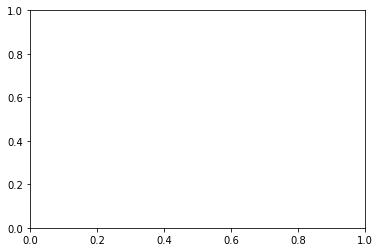

In [19]:
import statistics

nb_vertex_matrix = 100
min_weight = 10
max_weight = 60
density = 0.5
nb_vertex_chosen = 30

population_min = 200
population_max = 500
nb_test = 10

bornes_tab = []

moyennes   = []
deviations = []

for po in range (population_min, population_max,25):
    for _ in range (nb_test):

        vertices_list = get_random_vertices_list(nb_vertex_matrix, nb_vertex_chosen)
        start_vertex = get_random_vertex(vertices_list)
        start_vertex_index = np.where(vertices_list == start_vertex)[0][0]

        interval_vertex = get_random_vertex(vertices_list)
        interval_vertex_index = np.where(vertices_list == interval_vertex)[0][0]

        interval = (0,100000000)

        # generation of the graph, the complete graph and the list of all paths
        graph, complete_graph, all_paths, all_vertex =\
        generate_instance(
        nb_vertex_matrix = nb_vertex_matrix,
        vertices_list = vertices_list,
        density = density
        )

        population = generate_population(po, complete_graph, interval, interval_vertex_index, start_vertex_index)
        best_path, best_weight, all_best_weights = evolve(population, complete_graph, interval, interval_vertex_index)
        borne_inf = Simplex(complete_graph)[1]
        distance_borne = borne_inf*100/best_weight
        bornes_tab.append(distance_borne)

        moyennes.append(statistics.fmean(bornes_tab))               #SOLUTION
        deviations.append(np.std(bornes_tab))

        print("distance",distance_borne)
        print("borne_inf",borne_inf)
        print("best_weight",best_weight)

plt.plot(moyennes)

# affichage de la bande d'écart-type
plt.fill_between(range(population_min, population_max),
                 np.subtract(moyennes, deviations), # borne haute
                 np.add(moyennes, deviations),      # borne basse
                 alpha=.1)                          # transparence
plt.xlabel("taille population")
plt.ylabel("Rapprochement de la distance à la borne en %")
plt.title("Impact de la taille de la population sur la qualité des solutions")
plt.show()

print(sum(bornes_tab) / len(bornes_tab))


Text(0.5, 1.0, 'Distribution des distances à la borne supérieure')

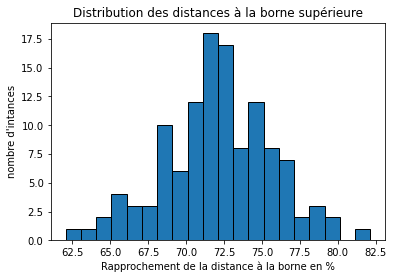

In [20]:
plt.hist(bornes_tab,bins=20, edgecolor = "black")                         
plt.xlabel("Rapprochement de la distance à la borne en %")                            
plt.ylabel("nombre d'intances")                               
plt.title("Distribution des distances à la borne supérieure") 

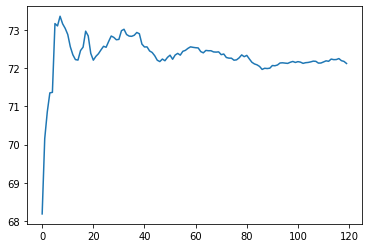

In [21]:
plt.plot(moyennes)
plt.xlabel("Rapprochement de la distance à la borne en %")                            
plt.ylabel("nombre d'intances")                               
plt.title("Distribution des distances à la borne supérieure")

In [1]:
"""plt.plot(moyennes)"""
print(moyennes)
"""plt.xlabel("Rapprochement de la distance à la borne en %")                             #SOLUTION
plt.ylabel("nombre d'intances")                               #SOLUTION
plt.title("Distribution des distances à la borne supérieure")"""

NameError: name 'moyennes' is not defined